In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
from medvqa.utils.files import load_pickle
from medvqa.evaluation.plots import plot_metrics, visualize_image_and_polygons
import numpy as np
import medvqa
import os
from importlib import reload
from medvqa.evaluation.plots import visualize_predicted_bounding_boxes__yolo
from medvqa.utils.constants import VINBIG_BBOX_NAMES
from medvqa.metrics.bbox.utils import compute_mAP__yolov11
from medvqa.utils.logging import print_magenta

In [76]:
reload(medvqa.evaluation.plots)

<module 'medvqa.evaluation.plots' from '/home/pamessina/medvqa/medvqa/evaluation/plots.py'>

In [3]:
# source: https://www.kaggle.com/competitions/vinbigdata-chest-xray-abnormalities-detection/data
VINBIGDATA_CHALLENGE_CLASSES = [
    'Aortic enlargement',
    'Atelectasis',
    'Calcification',
    'Cardiomegaly',
    'Consolidation',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Nodule/Mass',
    'Other lesion',
    'Pleural effusion',
    'Pleural thickening',
    'Pneumothorax',
    'Pulmonary fibrosis',
]
assert all(x in VINBIG_BBOX_NAMES for x in VINBIGDATA_CHALLENGE_CLASSES)

# source: https://github.com/philip-mueller/chex/blob/main/conf/dataset/class_names/vindrcxr_loc_top15.yaml
CHEX_CLASSES = [
    'Aortic enlargement',
    'Atelectasis',
    'Cardiomegaly',
    'Calcification',
    'Consolidation',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Mediastinal shift',
    'Nodule/Mass',
    'Pulmonary fibrosis',
    'Pneumothorax',
    'Pleural thickening',
    'Pleural effusion',
    'Other lesion',
]
assert all(x in VINBIG_BBOX_NAMES for x in CHEX_CLASSES)

CHEX_IOU_THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [4]:
def compute_map_metrics_from_results(results_path, iou_thresholds = [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]):
    results = load_pickle(results_path)
    res = compute_mAP__yolov11(
        gt_coords=results['gt_bboxes'],
        pred_boxes=results['pred_boxes_list'],
        pred_classes=results['pred_classes_list'],
        pred_confs=results['pred_confs_list'],
        classifier_confs=results['classifier_confs'],
        iou_thresholds=iou_thresholds,
        compute_micro_average=True,
    )
    class_aps = res['class_aps']
    micro_aps = res['micro_aps']
        
    for iou_thresh, map_ in zip(iou_thresholds, class_aps.mean(axis=1)):
        print_magenta(f'mAP@{iou_thresh}: {map_}', bold=True)

    for iou_thresh, ap in zip(iou_thresholds, micro_aps):
        print_magenta(f'micro_AP@{iou_thresh}: {ap}', bold=True)
        
    # vinbigdata metric
    class_idxs = [VINBIG_BBOX_NAMES.index(x) for x in VINBIGDATA_CHALLENGE_CLASSES]
    iou_idx = iou_thresholds.index(0.4)
    mAP = class_aps[iou_idx, class_idxs].mean()
    print_magenta(f'vinbigdata mAP@0.4: {mAP}', bold=True)

    # ChEX metric
    class_idxs = [VINBIG_BBOX_NAMES.index(x) for x in CHEX_CLASSES]
    iou_idxs = [iou_thresholds.index(x) for x in CHEX_IOU_THRESHOLDS]
    mAP = class_aps[iou_idxs][:, class_idxs].mean()
    print_magenta(f'ChEX mAP@{CHEX_IOU_THRESHOLDS}: {mAP}', bold=True)

# 1) Phrase Grounding: DenseNet121 + CXRFE + Sigmoid-based attention

In [9]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: densenet-121
create_densenet121_feature_extra

In [11]:
tmp1 = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)/vindrcxr_metrics.pkl')

In [129]:
tmp = tmp1

In [130]:
tmp.keys()

dict_keys(['image_paths', 'phrases', 'pred_masks', 'gt_masks', 'ious', 'segmask_iou', 'prc_auc'])

posx and posy should be finite values


posx and posy should be finite values


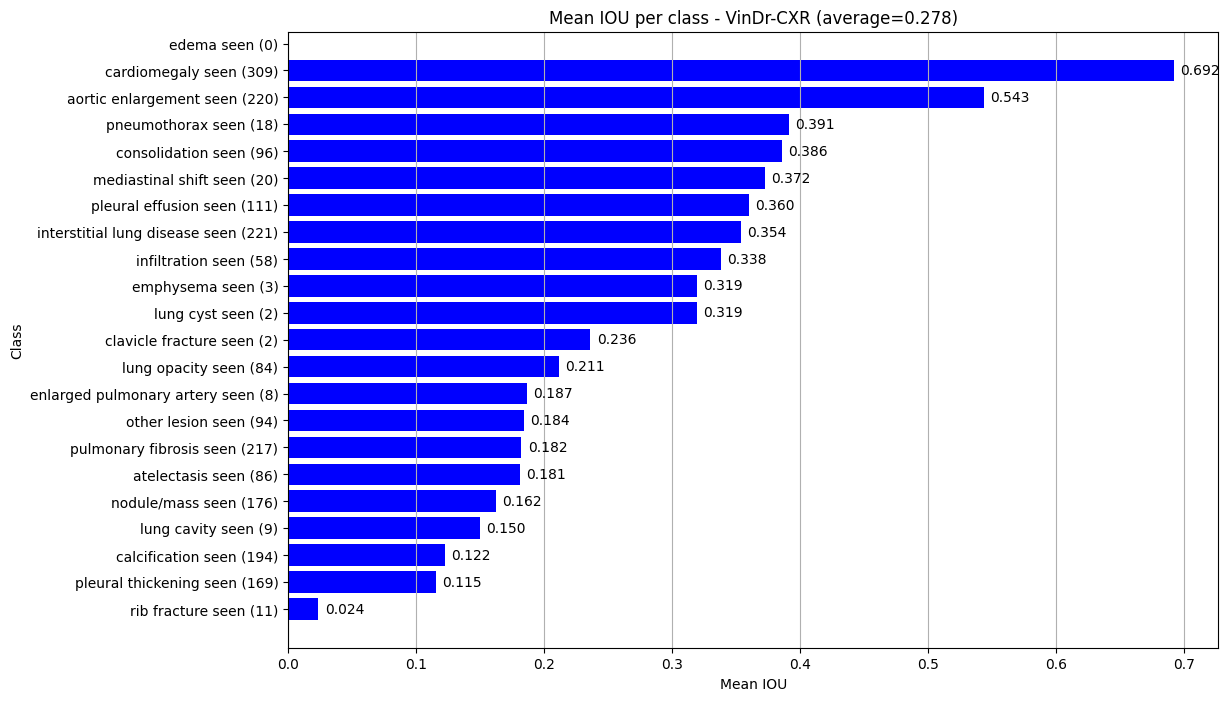

In [131]:
from medvqa.utils.constants import VINBIG_BBOX_NAMES, VINBIG_LABEL2PHRASE

vinbig_phrases = [VINBIG_LABEL2PHRASE[x] for x in VINBIG_BBOX_NAMES]
phrase2idxs = { x:[] for x in vinbig_phrases }
for idx, phrase in enumerate(tmp['phrases']):
    phrase2idxs[phrase].append(idx)

phrase2mean_iou = {}
for phrase, idxs in phrase2idxs.items():
    phrase2mean_iou[phrase] = np.mean([tmp['ious'][idx] for idx in idxs])

plot_metrics(
    metric_names=[f'{name} ({len(phrase2idxs[name])})' for name in vinbig_phrases],
    metric_values=[phrase2mean_iou[phrase] for phrase in vinbig_phrases],
    title='Mean IOU per class - VinDr-CXR',
    ylabel='Class',
    xlabel='Mean IOU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

In [19]:
from medvqa.evaluation.plots import visualize_attention_maps

In [49]:
idxs = np.argsort(tmp['ious'])[::-1]
len(idxs)

2108

In [77]:
# idx = idxs[-200]
idx = idxs[200]
print(tmp['ious'][idx])
print()
print(tmp['image_paths'][idx])
print()
print(tmp['phrases'][idx])

0.7070717811584473

/mnt/workspace/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/889347926c284c6c61234b357153d327.jpg

interstitial lung disease seen


In [26]:
from medvqa.datasets.vinbig import load_test_image_id_2_bboxes, visualize_image_with_bounding_boxes
test_image_id_2_bboxes = load_test_image_id_2_bboxes()

Anomalous bboxes found: 0 of 2697


image_path: /mnt/workspace/vinbig-cxr/dataset-jpg/images/889347926c284c6c61234b357153d327.jpg
0: ILD
[[335.2509977817093, 551.816172253801, 788.6113235322391, 1605.0496119547272], [1269.6155715846303, 485.4707587293333, 1753.3842118672085, 1563.5837285019347]]


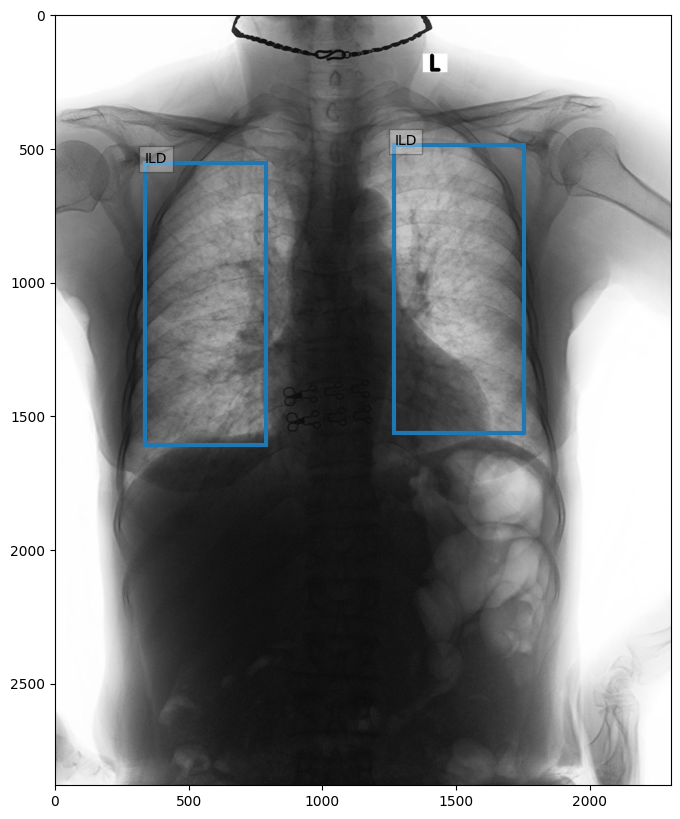

In [78]:
key = os.path.basename(tmp['image_paths'][idx])[:-4]
visualize_image_with_bounding_boxes(key, test_image_id_2_bboxes[key], verbose=True)

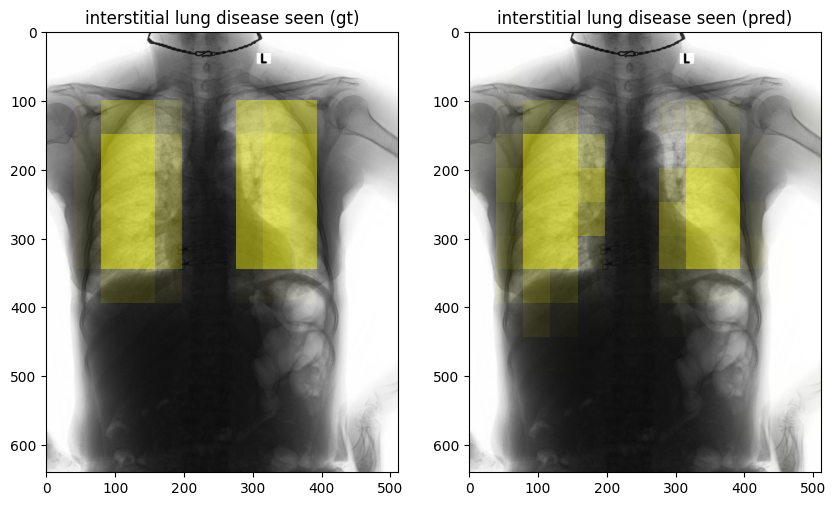

In [79]:
visualize_attention_maps(
    image_path=tmp['image_paths'][idx],
    figsize=(10,10),
    attention_factor=0.5,
    attention_maps=[
        tmp['gt_masks'][idx].reshape(13,13),
        tmp['pred_masks'][idx].reshape(13,13),
    ],
    titles=[
        f"{tmp['phrases'][idx]} (gt)",
        f"{tmp['phrases'][idx]} (pred)",
    ],
)

# 2) Phrase Grounding: DenseNet121 + CXRFE + Transformer Encoder

In [80]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_093614_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,4,512,3)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_093614_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,4,512,3)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_093614_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,4,512,3)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: densenet-121
create_densenet121_featu

# 3) Phrase Grounding: DenseNet121 + CXRFE + FiLM-based attention

In [81]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240705_131322_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,FiLM_SigmoidAttention,128,256,256,256,1,256-128)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240705_131322_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,FiLM_SigmoidAttention,128,256,256,256,1,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240705_131322_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,FiLM_SigmoidAttention,128,256,256,256,1,256-128)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: densenet-12

In [82]:
tmp3 = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20240705_131322_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,FiLM_SigmoidAttention,128,256,256,256,1,256-128)/vindrcxr_metrics.pkl')

In [126]:
tmp = tmp3

In [127]:
tmp.keys()

dict_keys(['image_paths', 'phrases', 'pred_masks', 'gt_masks', 'ious', 'segmask_iou', 'prc_auc'])

posx and posy should be finite values


posx and posy should be finite values


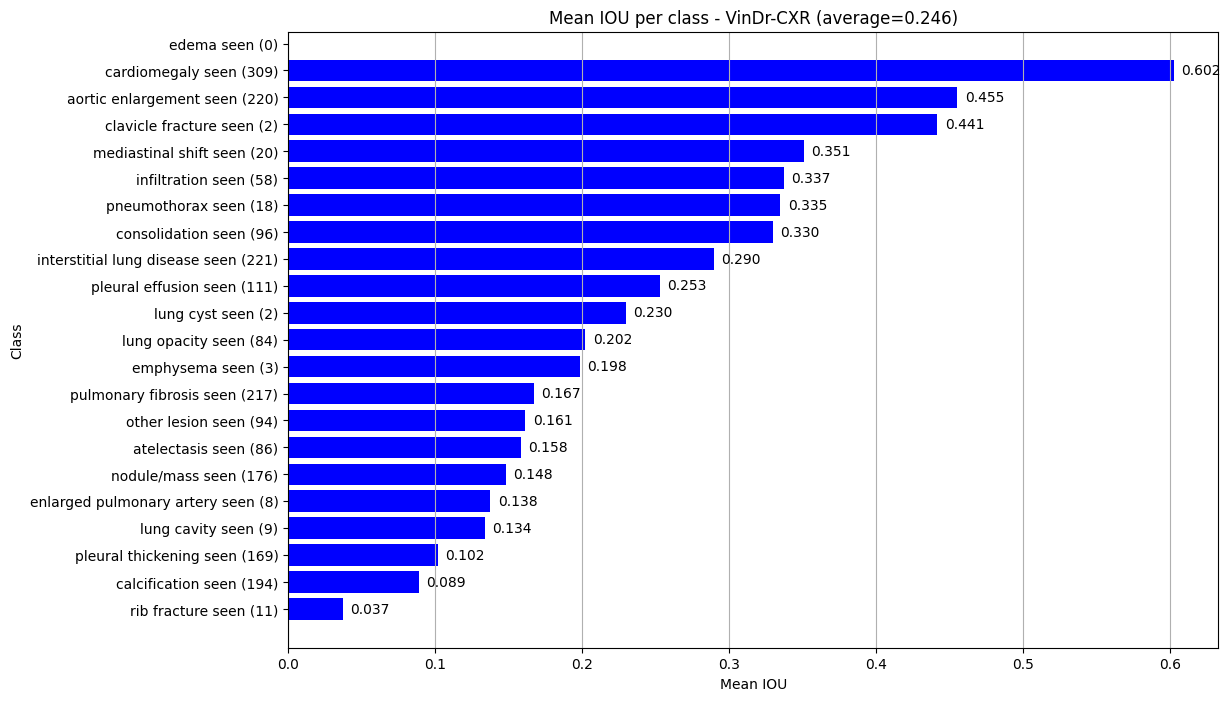

In [128]:
from medvqa.utils.constants import VINBIG_BBOX_NAMES, VINBIG_LABEL2PHRASE

vinbig_phrases = [VINBIG_LABEL2PHRASE[x] for x in VINBIG_BBOX_NAMES]
phrase2idxs = { x:[] for x in vinbig_phrases }
for idx, phrase in enumerate(tmp['phrases']):
    phrase2idxs[phrase].append(idx)

phrase2mean_iou = {}
for phrase, idxs in phrase2idxs.items():
    phrase2mean_iou[phrase] = np.mean([tmp['ious'][idx] for idx in idxs])

plot_metrics(
    metric_names=[f'{name} ({len(phrase2idxs[name])})' for name in vinbig_phrases],
    metric_values=[phrase2mean_iou[phrase] for phrase in vinbig_phrases],
    title='Mean IOU per class - VinDr-CXR',
    ylabel='Class',
    xlabel='Mean IOU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

In [87]:
idxs = np.argsort(tmp['ious'])[::-1]
len(idxs)

2108

In [116]:
# idx = idxs[-200]
idx = idxs[-500]
print(tmp['ious'][idx])
print()
print(tmp['image_paths'][idx])
print()
print(tmp['phrases'][idx])

0.06893625110387802

/mnt/workspace/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/b856f3db2491d631aa4300206b97ff82.jpg

pulmonary fibrosis seen


image_path: /mnt/workspace/vinbig-cxr/dataset-jpg/images/b856f3db2491d631aa4300206b97ff82.jpg
0: ILD
[[456.8576358404049, 1316.1147173953464, 1046.6127684311336, 1896.35767042816]]
1: Nodule/Mass
[[725.2047387729664, 1460.8034860750136, 1043.8627539631182, 1734.278648365069]]
2: Pleural effusion
[[335.5773464769885, 1630.0166428065406, 689.9060350093217, 1939.1624784387773]]
3: Pleural thickening
[[2085.442266866496, 1979.2380226523337, 2181.980020369589, 2239.889957110689]]
4: Pulmonary fibrosis
[[418.8089176087447, 1194.8344280319302, 789.7839203674289, 1356.541480516485]]


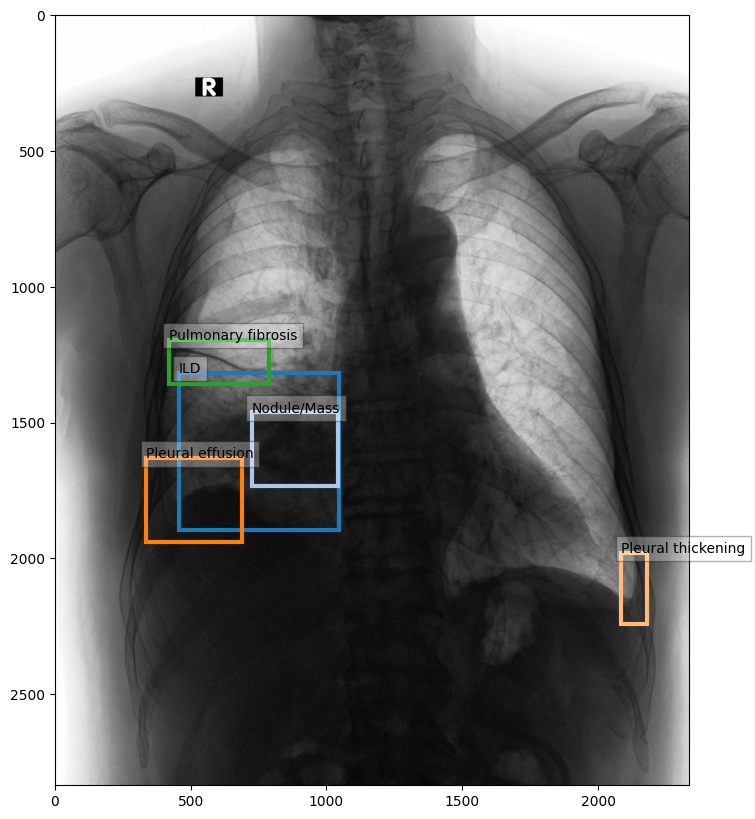

In [117]:
key = os.path.basename(tmp['image_paths'][idx])[:-4]
visualize_image_with_bounding_boxes(key, test_image_id_2_bboxes[key], verbose=True)

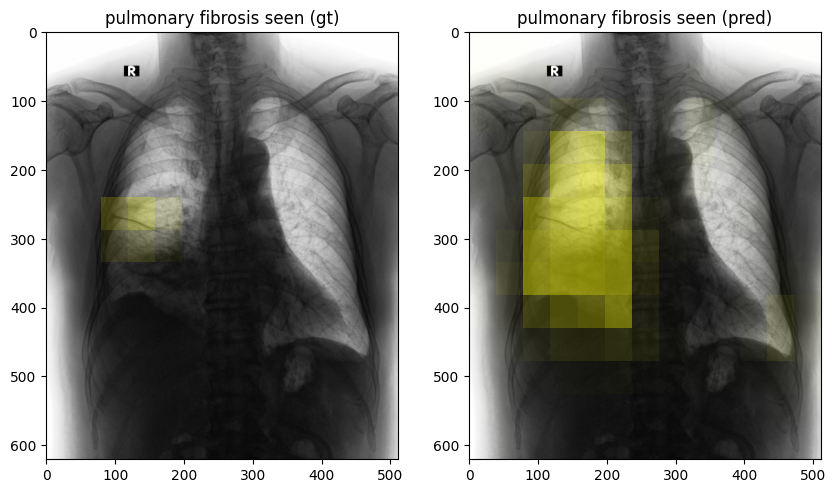

In [118]:
visualize_attention_maps(
    image_path=tmp['image_paths'][idx],
    figsize=(10,10),
    attention_factor=0.5,
    attention_maps=[
        tmp['gt_masks'][idx].reshape(13,13),
        tmp['pred_masks'][idx].reshape(13,13),
    ],
    titles=[
        f"{tmp['phrases'][idx]} (gt)",
        f"{tmp['phrases'][idx]} (pred)",
    ],
)

In [90]:
from medvqa.datasets.vinbig import load_train_image_id_2_bboxes

In [91]:
train_image_id_2_bboxes = load_train_image_id_2_bboxes()

Anomalous bboxes found: 0 of 37367


image_path: /mnt/workspace/vinbig-cxr/dataset-jpg/images/0007d316f756b3fa0baea2ff514ce945.jpg
0: Aortic enlargement
[[1275.2900390625, 1039.9000244141, 1498.7099609375, 1241.6199951172], [1235.9799804688, 1021.6400146484, 1482.9000244141, 1281.9799804688]]
1: Cardiomegaly
[[902.03997802734, 1827.7399902344, 1829.6700439453, 2037.0200195312]]
2: ILD
[[1847.3100585938, 1409.9899902344, 2093.1201171875, 2096.5500488281], [535.40399169922, 1748.9799804688, 932.21997070312, 2013.0600585938]]
3: Pleural thickening
[[818.666015625, 677.09802246094, 987.66998291016, 939.34497070312], [621.36499023438, 673.40600585938, 1025.8599853516, 851.7340087890599], [790.0479736328099, 634.90301513672, 1047.8399658203, 725.0390014648401]]
4: Pulmonary fibrosis
[[818.666015625, 677.09802246094, 987.66998291016, 939.34497070312], [804.0040283203099, 716.57000732422, 857.5239868164099, 920.35797119141], [1392.7199707031, 702.15997314453, 1518.2900390625, 790.67401123047]]


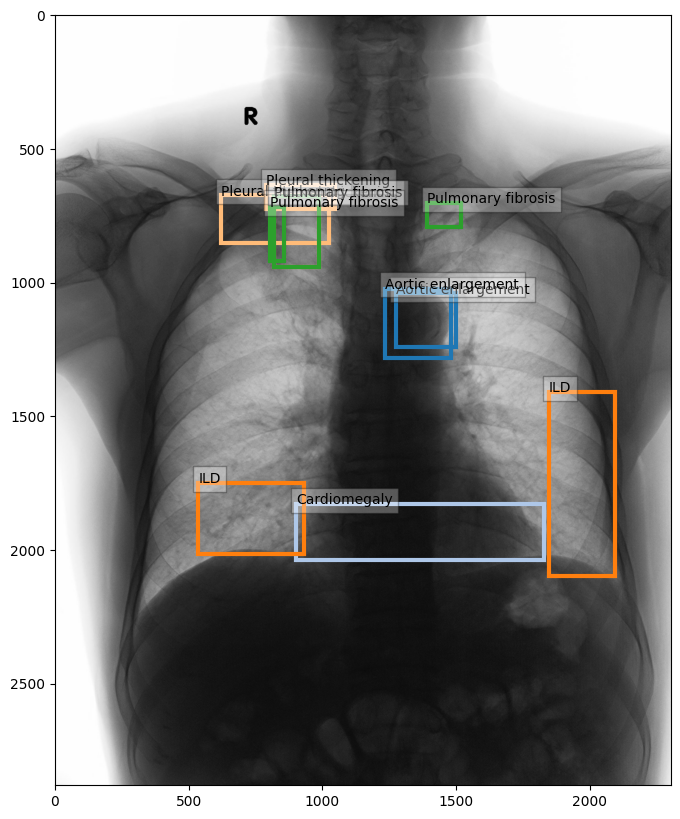

In [11]:
key = os.path.basename('/mnt/workspace/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/0007d316f756b3fa0baea2ff514ce945.jpg')[:-4]
visualize_image_with_bounding_boxes(key, train_image_id_2_bboxes[key], verbose=True)

# 4) Phrase Grounding: DN121+CXRFE+FiLM+bbox (VinDR-CXR)

In [75]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPu

In [314]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241128_153116_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig \
--use_amp

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241128_153116_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: True
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241128_153116_vinbig_PhraseGrounde

conf_th=0.2, iou_th=0.3, mAP=0.1589726362394991 (time_input_processing=1.8959667682647705, time_map=3.063363552093506)
conf_th=0.2, iou_th=0.4, mAP=0.15851107845651716 (time_input_processing=1.9004037380218506, time_map=3.484243392944336)
conf_th=0.2, iou_th=0.5, mAP=0.1540548961216925 (time_input_processing=2.158745050430298, time_map=4.115062475204468)
conf_th=0.3, iou_th=0.02, mAP=0.1552950837733238 (time_input_processing=1.8517069816589355, time_map=2.000192880630493)
conf_th=0.3, iou_th=0.05, mAP=0.15525899889389516 (time_input_processing=1.8519091606140137, time_map=2.050588607788086)
conf_th=0.3, iou_th=0.1, mAP=0.15621570737880364 (time_input_processing=1.8479290008544922, time_map=2.151925802230835)
conf_th=0.3, iou_th=0.2, mAP=0.15481551566131488 (time_input_processing=2.108630895614624, time_map=2.4268438816070557)
conf_th=0.3, iou_th=0.3, mAP=0.15888257568099867 (time_input_processing=1.8540863990783691, time_map=2.760392427444458)
conf_th=0.3, iou_th=0.4, mAP=0.15845454414

In [41]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241128_153116_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.30,0.40,50),use_classifier_confs).pkl')

mAP@0.0: 0.2897951782120265
mAP@0.02: 0.24109310797489647
mAP@0.05: 0.2221399704063156
mAP@0.1: 0.1903686730162686
mAP@0.2: 0.14083659008877594
mAP@0.3: 0.11730951307615438
mAP@0.4: 0.09665405579539231
mAP@0.5: 0.07596140180488084
mAP@0.6: 0.05862090089547241
mAP@0.7: 0.042644597958426685
micro_AP@0.0: 0.40431341033366697
micro_AP@0.02: 0.3708038685016486
micro_AP@0.05: 0.34551120225159165
micro_AP@0.1: 0.30354943661943745
micro_AP@0.2: 0.2472684429412056
micro_AP@0.3: 0.20734579123003638
micro_AP@0.4: 0.17593476477066627
micro_AP@0.5: 0.13837399425249688
micro_AP@0.6: 0.09775810611428801
micro_AP@0.7: 0.054267491388075365
vinbigdata mAP@0.4: 0.14441048881585633
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.1476147000138287


In [109]:
tmp = load_pickle("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl")

In [110]:
tmp.keys()

dict_keys(['image_paths', 'phrases', 'pred_bboxes', 'gt_bboxes', 'ious', 'bbox_iou', 'prc_auc'])

In [141]:
from medvqa.utils.files import get_cached_pickle_file
from medvqa.utils.constants import VINBIG_BBOX_NAMES, VINBIG_LABEL2PHRASE

def iou_macro_average(metrics_path):
    tmp = get_cached_pickle_file(metrics_path)
    phrase2idxs = { x:[] for x in vinbig_phrases }
    for idx, phrase in enumerate(tmp['phrases']):
        phrase2idxs[phrase].append(idx)
    
    count = 0
    acc_iou = 0
    for idxs in phrase2idxs.values():
        if len(idxs) > 0:
            acc_iou += np.mean([tmp['ious'][idx] for idx in idxs])
            count += 1
    assert count > 0
    return acc_iou / count

In [142]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.16353653144077654

/home/pamessina/venv2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pamessina/venv2/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
posx and posy should be finite values


posx and posy should be finite values


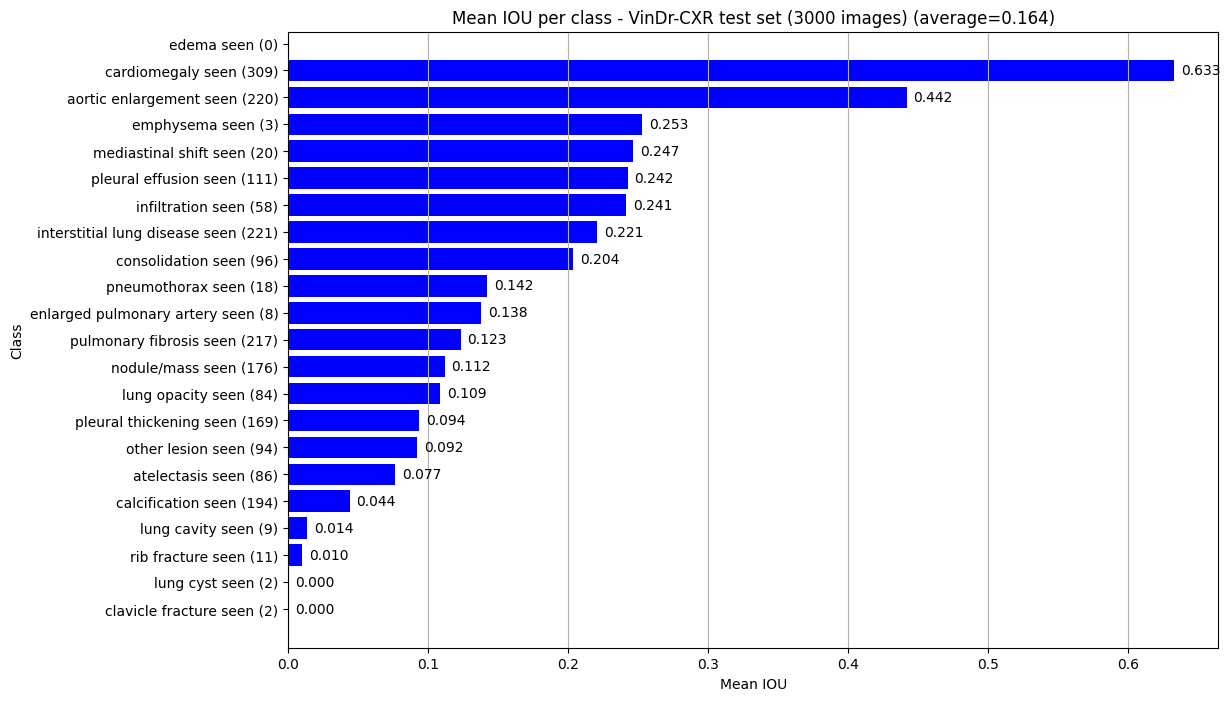

In [117]:


vinbig_phrases = [VINBIG_LABEL2PHRASE[x] for x in VINBIG_BBOX_NAMES]
phrase2idxs = { x:[] for x in vinbig_phrases }
for idx, phrase in enumerate(tmp['phrases']):
    phrase2idxs[phrase].append(idx)

phrase2mean_iou = {}
for phrase, idxs in phrase2idxs.items():
    phrase2mean_iou[phrase] = np.mean([tmp['ious'][idx] for idx in idxs])

plot_metrics(
    metric_names=[f'{name} ({len(phrase2idxs[name])})' for name in vinbig_phrases],
    metric_values=[phrase2mean_iou[phrase] for phrase in vinbig_phrases],
    title='Mean IOU per class - VinDr-CXR test set (3000 images)',
    ylabel='Class',
    xlabel='Mean IOU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

In [68]:
reload(medvqa.datasets.vinbig)

<module 'medvqa.datasets.vinbig' from '/home/pamessina/medvqa/medvqa/datasets/vinbig/__init__.py'>

In [69]:
from medvqa.datasets.vinbig import compute_label_frequencies

In [70]:
label_frequencies = compute_label_frequencies()

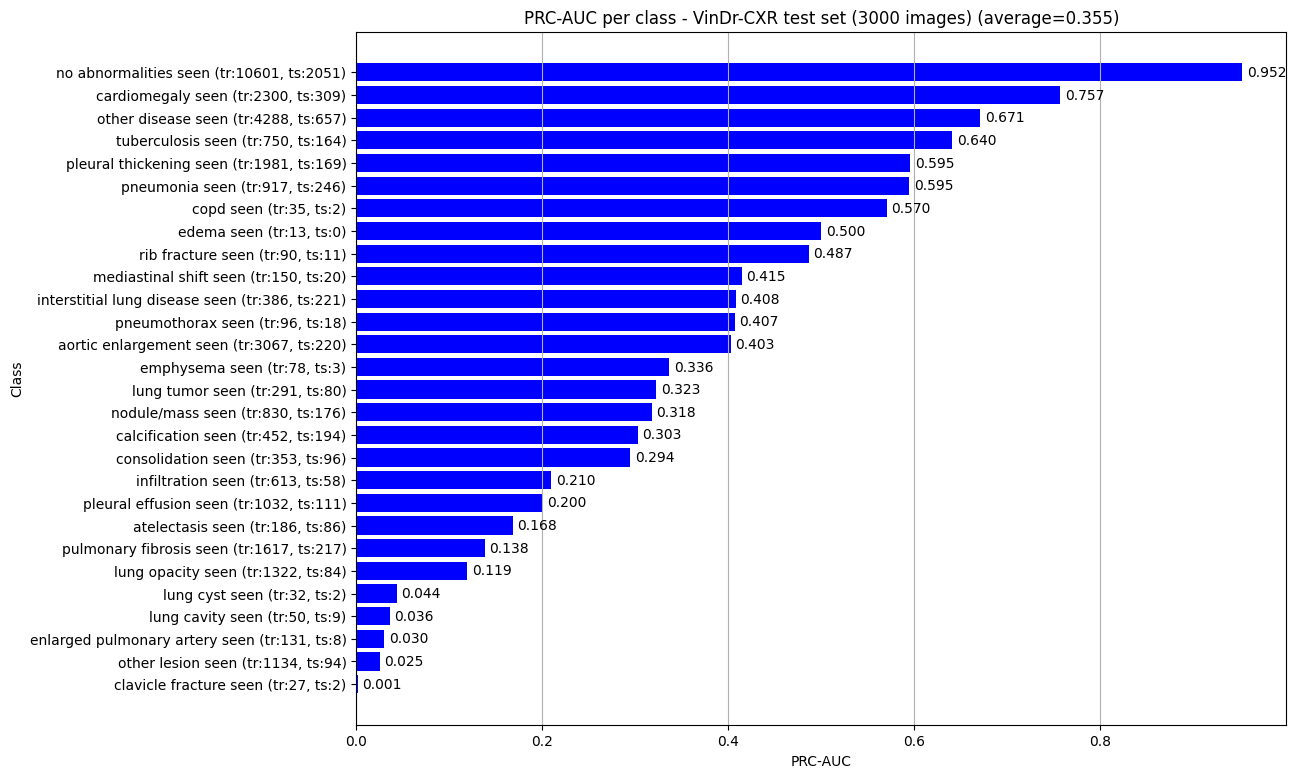

In [118]:
from medvqa.utils.constants import VINBIG_LABELS, VINBIG_LABEL2PHRASE

plot_metrics(
    metric_names=[f'{VINBIG_LABEL2PHRASE[x]} (tr:{label_frequencies["train"][x]}, ts:{label_frequencies["test"][x]})' for x in VINBIG_LABELS],
    metric_values=tmp['prc_auc']['per_class'],
    title='PRC-AUC per class - VinDr-CXR test set (3000 images)',
    ylabel='Class',
    xlabel='PRC-AUC',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 9),
    append_average_to_title=True,
)

In [119]:
idxs = np.argsort(tmp['ious'])[::-1]
len(idxs)

2108

In [133]:
idx = idxs[-10]
print(tmp['ious'][idx])
print()
print(tmp['image_paths'][idx])
print()
print(tmp['phrases'][idx])

0

/mnt/data/chest_related_backup/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/c28e30456f3d1b1dda8a22f958b7aa96.jpg

consolidation seen


image_path: /mnt/data/chest_related_backup/vinbig-cxr/dataset-jpg/images/c28e30456f3d1b1dda8a22f958b7aa96.jpg
0: Consolidation
[[1234.2674134950737, 1197.0789112898806, 1561.2234809904303, 1504.8022689325694]]


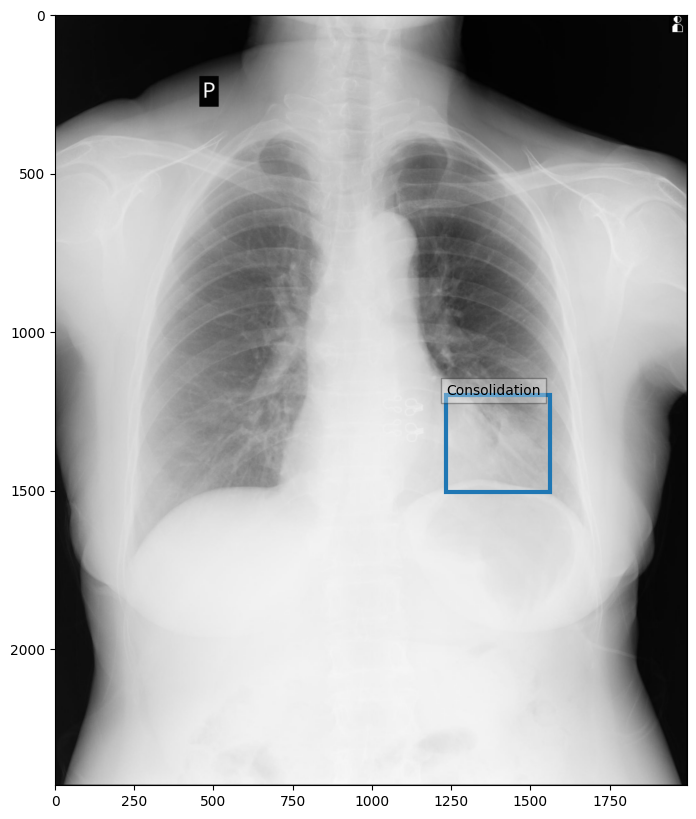

In [134]:
key = os.path.basename(tmp['image_paths'][idx])[:-4]
visualize_image_with_bounding_boxes(key, test_image_id_2_bboxes[key], verbose=True)

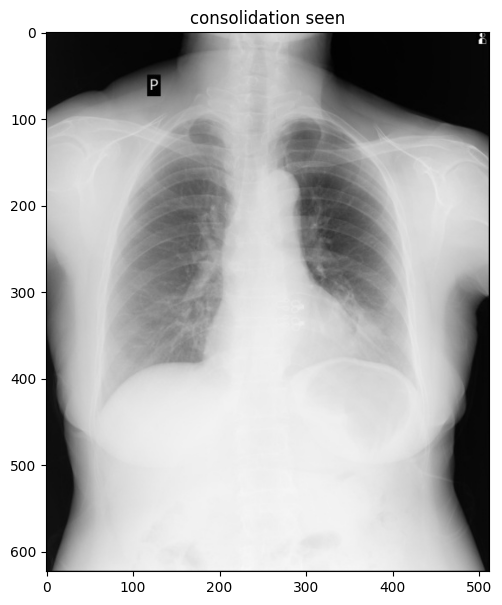

In [135]:
from medvqa.evaluation.plots import visualize_visual_grounding_as_bboxes
visualize_visual_grounding_as_bboxes(
    image_path=tmp['image_paths'][idx],
    phrases=[tmp['phrases'][idx]],
    bboxes=[tmp['pred_bboxes'][idx]] if tmp['pred_bboxes'][idx] is not None else [[]],
    figsize=(7, 7),
    max_cols=1,
)

In [74]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig \
--vinbig_use_training_indices_for_validation

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPur

In [76]:
tmp2 = load_pickle("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression).pkl")

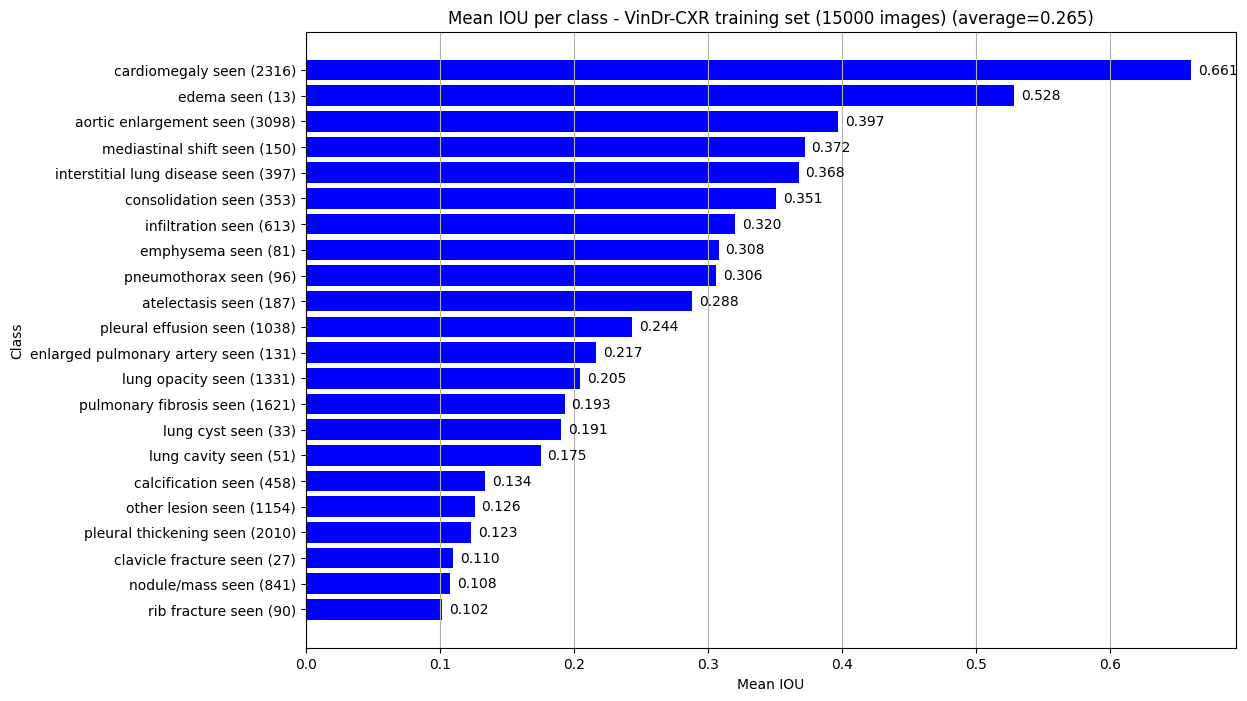

In [81]:
from medvqa.utils.constants import VINBIG_BBOX_NAMES, VINBIG_LABEL2PHRASE

vinbig_phrases = [VINBIG_LABEL2PHRASE[x] for x in VINBIG_BBOX_NAMES]
phrase2idxs = { x:[] for x in vinbig_phrases }
for idx, phrase in enumerate(tmp2['phrases']):
    phrase2idxs[phrase].append(idx)

phrase2mean_iou = {}
for phrase, idxs in phrase2idxs.items():
    phrase2mean_iou[phrase] = np.mean([tmp2['ious'][idx] for idx in idxs])

plot_metrics(
    metric_names=[f'{name} ({len(phrase2idxs[name])})' for name in vinbig_phrases],
    metric_values=[phrase2mean_iou[phrase] for phrase in vinbig_phrases],
    title='Mean IOU per class - VinDr-CXR training set (15000 images)',
    ylabel='Class',
    xlabel='Mean IOU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

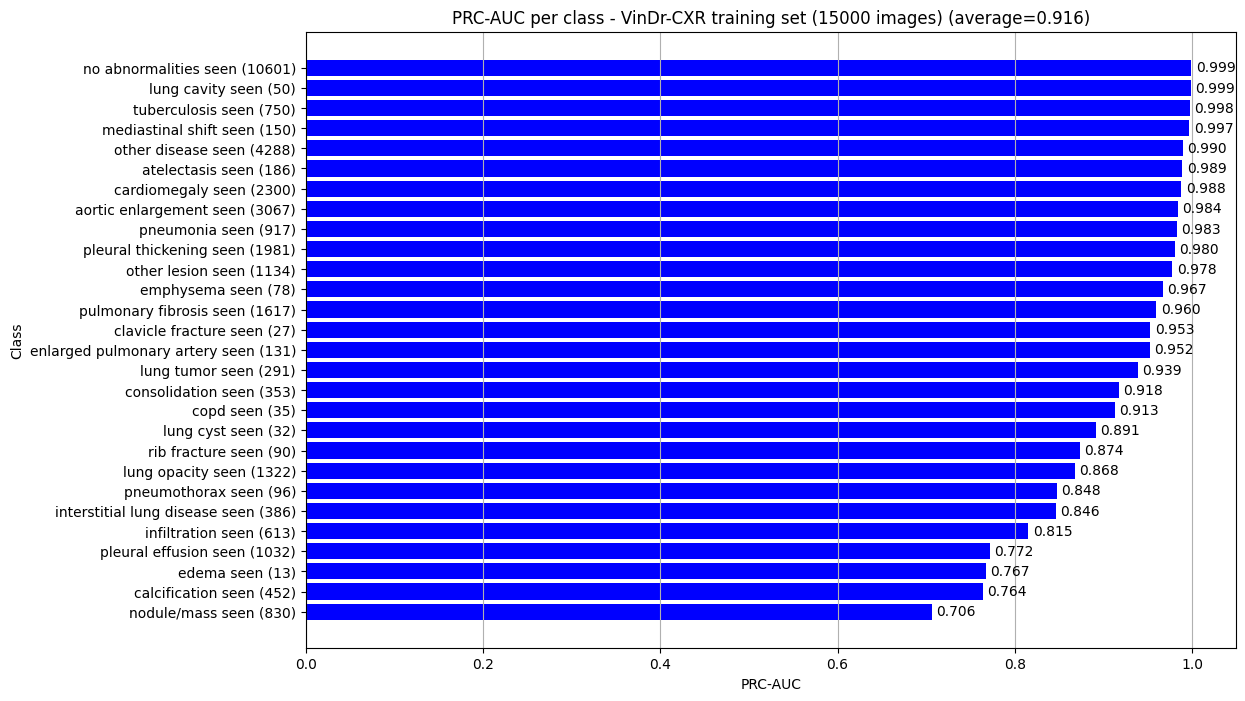

In [83]:
plot_metrics(
    metric_names=[f'{VINBIG_LABEL2PHRASE[x]} ({label_frequencies["train"][x]})' for x in VINBIG_LABELS],
    metric_values=tmp2['prc_auc']['per_class'],
    title='PRC-AUC per class - VinDr-CXR training set (15000 images)',
    ylabel='Class',
    xlabel='PRC-AUC',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

In [86]:
idxs = np.argsort(tmp2['ious'])[::-1]
len(idxs)

16089

In [104]:
idx = idxs[-1000]
print(tmp2['ious'][idx])
print()
print(tmp2['image_paths'][idx])
print()
print(tmp2['phrases'][idx])

0.01016150708654602

/mnt/data/chest_related_backup/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/afb41a2217d37b54f0427fc1c69336be.jpg

pulmonary fibrosis seen


image_path: /mnt/data/chest_related_backup/vinbig-cxr/dataset-jpg/images/afb41a2217d37b54f0427fc1c69336be.jpg
0: Consolidation
[[702.4110107421901, 1225.1600341797, 1186.9799804688, 1614.6899414062]]
1: Infiltration
[[645.81799316406, 1281.3299560547, 1115.6899414062, 1657.7900390625], [670.5830078125, 1128.7399902344, 1167.3100585938, 1650.1600341797]]
2: Lung Opacity
[[670.5830078125, 1128.7399902344, 1167.3100585938, 1650.1600341797]]
3: Pleural thickening
[[904.57000732422, 345.76998901367006, 1203.4699707031, 500.55499267578006]]
4: Pulmonary fibrosis
[[781.3980102539099, 814.30200195312, 852.4520263671901, 880.28100585938]]


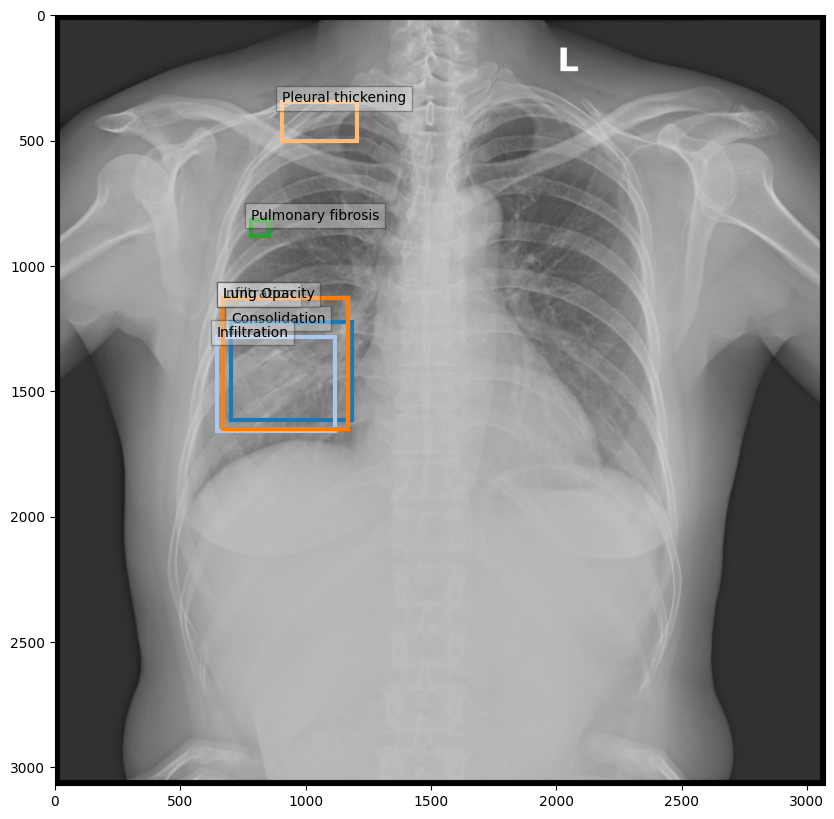

In [105]:
key = os.path.basename(tmp2['image_paths'][idx])[:-4]
visualize_image_with_bounding_boxes(key, train_image_id_2_bboxes[key], verbose=True)

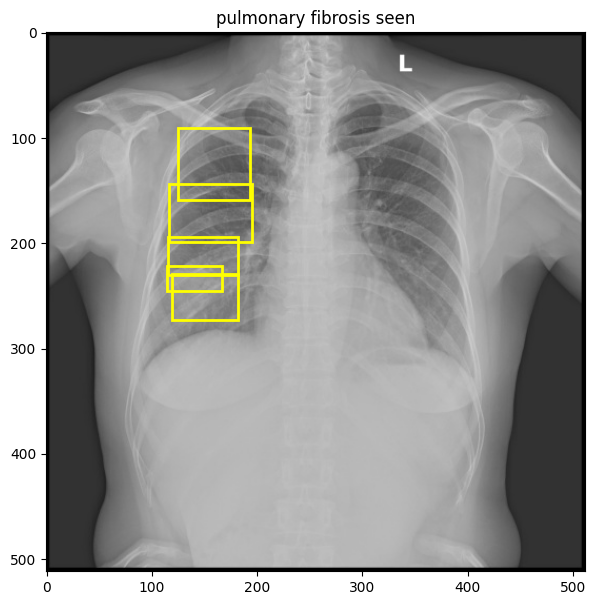

In [106]:
from medvqa.evaluation.plots import visualize_visual_grounding_as_bboxes
visualize_visual_grounding_as_bboxes(
    image_path=tmp2['image_paths'][idx],
    phrases=[tmp2['phrases'][idx]],
    bboxes=[tmp2['pred_bboxes'][idx]] if tmp2['pred_bboxes'][idx] is not None else [[]],
    figsize=(7, 7),
    max_cols=1,
)

# 5) Phrase Grounding: DN121+CXRFE+FiLM+bbox; Chest ImaGenome + VinDR-CXR

In [107]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance o

In [143]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.14017660799139942

In [311]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-

conf_th=0.2, iou_th=0.2, mAP=0.10186465944381569 (time_input_processing=2.0248382091522217, time_map=3.0251171588897705)
conf_th=0.2, iou_th=0.3, mAP=0.10082598605000724 (time_input_processing=2.2953073978424072, time_map=3.6223721504211426)
conf_th=0.2, iou_th=0.4, mAP=0.10095420678776504 (time_input_processing=1.996204137802124, time_map=4.403188943862915)
conf_th=0.2, iou_th=0.5, mAP=0.10026306132685069 (time_input_processing=2.000032901763916, time_map=5.68297815322876)
conf_th=0.3, iou_th=0.02, mAP=0.10402990990329891 (time_input_processing=1.9782485961914062, time_map=2.2034034729003906)
conf_th=0.3, iou_th=0.05, mAP=0.10292990271491692 (time_input_processing=1.9743216037750244, time_map=2.554919719696045)
conf_th=0.3, iou_th=0.1, mAP=0.10264670320115897 (time_input_processing=1.9792866706848145, time_map=2.438201665878296)
conf_th=0.3, iou_th=0.2, mAP=0.10095572911671041 (time_input_processing=1.9816555976867676, time_map=3.1297547817230225)
conf_th=0.3, iou_th=0.3, mAP=0.100807

In [39]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.02,0.10,50),use_classifier_confs).pkl')

mAP@0.0: 0.22218019263421496
mAP@0.02: 0.1535871067957074
mAP@0.05: 0.1420744101822133
mAP@0.1: 0.1229553758480865
mAP@0.2: 0.09798163137624365
mAP@0.3: 0.08081227105958926
mAP@0.4: 0.06816064220268757
mAP@0.5: 0.05384833086379573
mAP@0.6: 0.04080402004842514
mAP@0.7: 0.032109578710220604
micro_AP@0.0: 0.2634950900270627
micro_AP@0.02: 0.21370652549997632
micro_AP@0.05: 0.20016152302727314
micro_AP@0.1: 0.17989601847601433
micro_AP@0.2: 0.1503661040743351
micro_AP@0.3: 0.13005369796820815
micro_AP@0.4: 0.10789931374352142
micro_AP@0.5: 0.07432640647343974
micro_AP@0.6: 0.04374982612508174
micro_AP@0.7: 0.0321709088380677
vinbigdata mAP@0.4: 0.09958735330587665
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.10311027162450978


# 6) Phrase Grounding: DN121+CXRFE+FiLM+bbox; Chest ImaGenome + VinDR-CXR + MIMIC-CXR (facts + GPT-4 labels)

In [136]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
--------------------------------------------------
1) device = cuda
---------------------

In [144]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.1521956186451413

In [310]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/" \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grou

conf_th=0.2, iou_th=0.05, mAP=0.11729295486746626 (time_input_processing=2.2565577030181885, time_map=2.727806329727173)
conf_th=0.2, iou_th=0.1, mAP=0.11633540051578728 (time_input_processing=1.9973723888397217, time_map=2.9368038177490234)
conf_th=0.2, iou_th=0.2, mAP=0.1165064511903442 (time_input_processing=1.9978480339050293, time_map=3.6885738372802734)
conf_th=0.2, iou_th=0.3, mAP=0.11885897020856935 (time_input_processing=2.0056300163269043, time_map=4.03694486618042)
conf_th=0.2, iou_th=0.4, mAP=0.11828319705039471 (time_input_processing=2.011373996734619, time_map=5.0844151973724365)
conf_th=0.2, iou_th=0.5, mAP=0.11993134284377654 (time_input_processing=2.013296127319336, time_map=5.771182060241699)
conf_th=0.3, iou_th=0.02, mAP=0.11857200594378878 (time_input_processing=1.9893605709075928, time_map=2.1964449882507324)
conf_th=0.3, iou_th=0.05, mAP=0.11694452796931384 (time_input_processing=2.0064337253570557, time_map=1.965209722518921)
conf_th=0.3, iou_th=0.1, mAP=0.116007

In [38]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.02,0.70,50),use_classifier_confs).pkl')

mAP@0.0: 0.25126326615389594
mAP@0.02: 0.1807348477495279
mAP@0.05: 0.16491040418330571
mAP@0.1: 0.14314264480591501
mAP@0.2: 0.11692658133294072
mAP@0.3: 0.09138503821253369
mAP@0.4: 0.07857715744941894
mAP@0.5: 0.07050439854197334
mAP@0.6: 0.05918951588955705
mAP@0.7: 0.04535414112797207
micro_AP@0.0: 0.28297186753065195
micro_AP@0.02: 0.23320766465507828
micro_AP@0.05: 0.2137991623499704
micro_AP@0.1: 0.18824719009836827
micro_AP@0.2: 0.15423983621935305
micro_AP@0.3: 0.12190127191331569
micro_AP@0.4: 0.10313516584377247
micro_AP@0.5: 0.09100580747792825
micro_AP@0.6: 0.07093458979247995
micro_AP@0.7: 0.04689065039264152
vinbigdata mAP@0.4: 0.1204036632421954
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.12568708272094092


# 7) DN121+CXRFE+Global Pooling+FiLM+MLP; VinDR-CXR

In [315]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241026_183113_vinbig_PhraseGrounder(dn121,GlobalPoolingFiLMMLP,128,256-128)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241026_183113_vinbig_PhraseGrounder(dn121,GlobalPoolingFiLMMLP,128,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241026_183113_vinbig_PhraseGrounder(dn121,GlobalPoolingFiLMMLP,128,256-128)/metadata.json
do_visual_grounding_with_bbox_

# 8) DN121+CXRFE+Global Pooling+Concat+MLP; VinDR-CXR

In [316]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241026_175236_vinbig_PhraseGrounder(dn121,GlobalPoolingConcatMLP,128,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241026_175236_vinbig_PhraseGrounder(dn121,GlobalPoolingConcatMLP,128,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241026_175236_vinbig_PhraseGrounder(dn121,GlobalPoolingConcatMLP,128,256-128)/metadata.json
do_visual_grounding_with_b

# 9) DN121+CXRFE+FiLM Attention Pooling+MLP; VinDR-CXR

In [317]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241027_005233_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241027_005233_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241027_005233_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP,128,256,256-128)/metadata.json
do_visual_grounding_with_bbox_

# 10) DN121+CXRFE+Transformer (classif. only); VinDR-CXR

In [318]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241027_005334_vinbig_PhraseGrounder(dn121,TransformerEncoder_NoGrounding,128,256,4,256,2)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241027_005334_vinbig_PhraseGrounder(dn121,TransformerEncoder_NoGrounding,128,256,4,256,2)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241027_005334_vinbig_PhraseGrounder(dn121,TransformerEncoder_NoGrounding,128,256,4,256,2)/metadata.json
do

# 11) DN121+CXRFE+Transformer+BBox+Classif; VinDR-CXR

In [153]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121,TransformerEncoder_BBoxRegression,128,256,4,256,2)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121,TransformerEncoder_BBoxRegression,128,256,4,256,2)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121,TransformerEncoder_BBoxRegression,128,256,4,256,2)/metadata.json
do_visual_grounding_with_bbox_regression = True
do_visual_grounding_with_segmentation = False
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance

In [154]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121,TransformerEncoder_BBoxRegression,128,256,4,256,2)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.11413830329169078

In [300]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121,TransformerEncoder_BBoxRegression,128,256,4,256,2)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121,TransformerEncoder_BBoxRegression,128,256,4,256,2)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121

conf_th=0.2, iou_th=0.5, mAP=0.13563813367743507 (time_input_processing=1.627943992614746, time_map=3.676935911178589)
conf_th=0.3, iou_th=0.02, mAP=0.13381928159178055 (time_input_processing=1.5815846920013428, time_map=1.7964768409729004)
conf_th=0.3, iou_th=0.05, mAP=0.13462077119040838 (time_input_processing=1.5820250511169434, time_map=1.8527426719665527)
conf_th=0.3, iou_th=0.1, mAP=0.13446295206118516 (time_input_processing=1.583618402481079, time_map=1.9590041637420654)
conf_th=0.3, iou_th=0.2, mAP=0.13435236082749438 (time_input_processing=1.5865767002105713, time_map=2.478414297103882)
conf_th=0.3, iou_th=0.3, mAP=0.13434030622361456 (time_input_processing=1.5894546508789062, time_map=2.5690228939056396)
conf_th=0.3, iou_th=0.4, mAP=0.13561769240547508 (time_input_processing=1.5823071002960205, time_map=2.916461706161499)
conf_th=0.3, iou_th=0.5, mAP=0.1352255173634387 (time_input_processing=1.593003273010254, time_map=3.3357887268066406)
conf_th=0.4, iou_th=0.02, mAP=0.13269

In [37]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121,TransformerEncoder_BBoxRegression,128,256,4,256,2)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.40,0.10,50),use_classifier_confs).pkl')

mAP@0.0: 0.28309233683319446
mAP@0.02: 0.22511022671478464
mAP@0.05: 0.19950404488953924
mAP@0.1: 0.16666205261935124
mAP@0.2: 0.12268325782516877
mAP@0.3: 0.09968534746244771
mAP@0.4: 0.07473495099587137
mAP@0.5: 0.0610739004059752
mAP@0.6: 0.044258883435927314
mAP@0.7: 0.035168979406193165
micro_AP@0.0: 0.38468460300338925
micro_AP@0.02: 0.34235446145873516
micro_AP@0.05: 0.3088394194556979
micro_AP@0.1: 0.2670651628459709
micro_AP@0.2: 0.20792149449197664
micro_AP@0.3: 0.1643169866814061
micro_AP@0.4: 0.13194025646855645
micro_AP@0.5: 0.10266535012644226
micro_AP@0.6: 0.06678538977646775
micro_AP@0.7: 0.04094833197764323
vinbigdata mAP@0.4: 0.11577699404415465
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.12176259381314564


# 12) aehrc-cxrmate-rrg24-uniformer+CXRFE+Transformer+BBox+Classif; VinDR-CXR

In [155]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241029_092356_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,TransformerEncoder_BBoxRegression,128,256,4,256,2)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241029_092356_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,TransformerEncoder_BBoxRegression,128,256,4,256,2)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241029_092356_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,TransformerEncoder_BBoxRegression,128,256,4,256,2)/metadata.json
do_visual_grounding_with_bbox_regression = True
do_visual_grounding_with_segmentation = False
--------------------------------------------------
1) device = cuda
-----------------------

In [156]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241029_092356_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,TransformerEncoder_BBoxRegression,128,256,4,256,2)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.14304222217816195

In [298]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241029_092356_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,TransformerEncoder_BBoxRegression,128,256,4,256,2)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241029_092356_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,TransformerEncoder_BBoxRegression,128,256,4,256,2)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241029_092356_vin

conf_th=0.2, iou_th=0.5, mAP=0.19441760859015955 (time_input_processing=1.4390716552734375, time_map=3.0499114990234375)
conf_th=0.3, iou_th=0.02, mAP=0.189575620863787 (time_input_processing=1.408747673034668, time_map=1.507448434829712)
conf_th=0.3, iou_th=0.05, mAP=0.19166873431996712 (time_input_processing=1.4025530815124512, time_map=1.551276445388794)
conf_th=0.3, iou_th=0.1, mAP=0.19370217158897038 (time_input_processing=1.4056627750396729, time_map=1.6593258380889893)
conf_th=0.3, iou_th=0.2, mAP=0.19292409185586742 (time_input_processing=1.4069797992706299, time_map=1.7942376136779785)
conf_th=0.3, iou_th=0.3, mAP=0.19622181776683084 (time_input_processing=1.4070916175842285, time_map=1.9996514320373535)
conf_th=0.3, iou_th=0.4, mAP=0.1946834887641203 (time_input_processing=1.4036262035369873, time_map=2.257585287094116)
conf_th=0.3, iou_th=0.5, mAP=0.19420019698810675 (time_input_processing=1.4079680442810059, time_map=2.5842959880828857)
conf_th=0.4, iou_th=0.02, mAP=0.18848

In [35]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241029_092356_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,TransformerEncoder_BBoxRegression,128,256,4,256,2)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.30,0.10,50),use_classifier_confs).pkl')

mAP@0.0: 0.34269842073246165
mAP@0.02: 0.3187746008320953
mAP@0.05: 0.29024189263928474
mAP@0.1: 0.2529910913321378
mAP@0.2: 0.1828452621689816
mAP@0.3: 0.13753497802555845
mAP@0.4: 0.10849279369268806
mAP@0.5: 0.08355606289481114
mAP@0.6: 0.0575064475256172
mAP@0.7: 0.03981577066097957
micro_AP@0.0: 0.44677907730310573
micro_AP@0.02: 0.41308522512773327
micro_AP@0.05: 0.3813122100472383
micro_AP@0.1: 0.329599029146572
micro_AP@0.2: 0.26319478431839105
micro_AP@0.3: 0.20923374110944154
micro_AP@0.4: 0.17275781536966484
micro_AP@0.5: 0.13146323674562077
micro_AP@0.6: 0.08731181266410692
micro_AP@0.7: 0.053138668019699034
vinbigdata mAP@0.4: 0.15950454881866857
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.16942759843669794


# 13) DN121+CXRFE+FiLM Attention Pooling+BBox+Classif; VinDR-CXR

In [157]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
do_visual_grounding_with_segmentation = False
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of 

In [158]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.16770028737995715

In [299]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,A

conf_th=0.2, iou_th=0.5, mAP=0.17510149494242 (time_input_processing=1.803011178970337, time_map=3.519442081451416)
conf_th=0.3, iou_th=0.02, mAP=0.17865229561728782 (time_input_processing=1.726893424987793, time_map=1.654174566268921)
conf_th=0.3, iou_th=0.05, mAP=0.18000644078764874 (time_input_processing=1.7593894004821777, time_map=1.71073317527771)
conf_th=0.3, iou_th=0.1, mAP=0.1799449062414996 (time_input_processing=1.7443161010742188, time_map=1.7830615043640137)
conf_th=0.3, iou_th=0.2, mAP=0.1766691516459239 (time_input_processing=1.72940993309021, time_map=1.978147029876709)
conf_th=0.3, iou_th=0.3, mAP=0.1780763734809259 (time_input_processing=1.738105058670044, time_map=2.23178768157959)
conf_th=0.3, iou_th=0.4, mAP=0.18082619232939232 (time_input_processing=2.0069258213043213, time_map=2.560245990753174)
conf_th=0.3, iou_th=0.5, mAP=0.17608449356081243 (time_input_processing=1.7558352947235107, time_map=2.972668170928955)
conf_th=0.4, iou_th=0.02, mAP=0.17767252092014557 

In [36]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.10,0.10,50),use_classifier_confs).pkl')

mAP@0.0: 0.3049304464933739
mAP@0.02: 0.276865717737862
mAP@0.05: 0.25568466813660756
mAP@0.1: 0.22852219367181215
mAP@0.2: 0.17833200216626327
mAP@0.3: 0.13437637276477027
mAP@0.4: 0.10806660831279259
mAP@0.5: 0.08099362843740293
mAP@0.6: 0.05680376723646208
mAP@0.7: 0.04214396233478191
micro_AP@0.0: 0.4204989791418739
micro_AP@0.02: 0.38359791056649833
micro_AP@0.05: 0.35461368359916984
micro_AP@0.1: 0.31695424581167275
micro_AP@0.2: 0.2548734917325021
micro_AP@0.3: 0.20009051669022015
micro_AP@0.4: 0.16561901501933607
micro_AP@0.5: 0.12555300075666653
micro_AP@0.6: 0.08196417139117976
micro_AP@0.7: 0.05020296299363561
vinbigdata mAP@0.4: 0.15199505350435086
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.16435638973046704


# 14) aehrc-cxrmate-rrg24-uniformer+CXRFE+FiLM Attention Pooling+BBox+Classif; VinDR-CXR

In [159]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
do_visual_grounding_with_segmentation = False
--------------------------------------------------
1) device = cuda
---------------------------

In [11]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_ML

mAP@0.0: 0.3270222751795983
mAP@0.02: 0.30464496114781264
mAP@0.05: 0.2841015274871012
mAP@0.1: 0.2544500602943272
mAP@0.2: 0.19478628572199874
mAP@0.3: 0.15587414090431256
mAP@0.4: 0.12134761001841224
mAP@0.5: 0.0973199767084087
Saving metrics to file ...
Saved metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl


In [13]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--vinbig_use_training_indices_for_validation \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: True
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   use_amp: False
   use_classifier_confs_for_map: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression

mAP@0.0: 0.7772638019107735
mAP@0.02: 0.7124620920347936
mAP@0.05: 0.6666609416256917
mAP@0.1: 0.6134811724383131
mAP@0.2: 0.5056653702980876
mAP@0.3: 0.4278481488817379
mAP@0.4: 0.34737825733194705
mAP@0.5: 0.27965363582609654
Saving metrics to file ...
Saved metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,15000).pkl


In [14]:
tmp_train = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,15000).pkl')

In [16]:
tmp_train.keys()

dict_keys(['image_paths', 'pred_boxes_list', 'pred_classes_list', 'pred_confs_list', 'classifier_confs', 'gt_bboxes', 'class_ious', 'sample_ious', 'micro_iou', 'macro_iou', 'map_iou_thresholds', 'map_per_class', 'prc_auc'])

In [17]:
tmp = tmp_train
idxs = np.argsort(tmp['sample_ious'])[::-1]

0.53710514


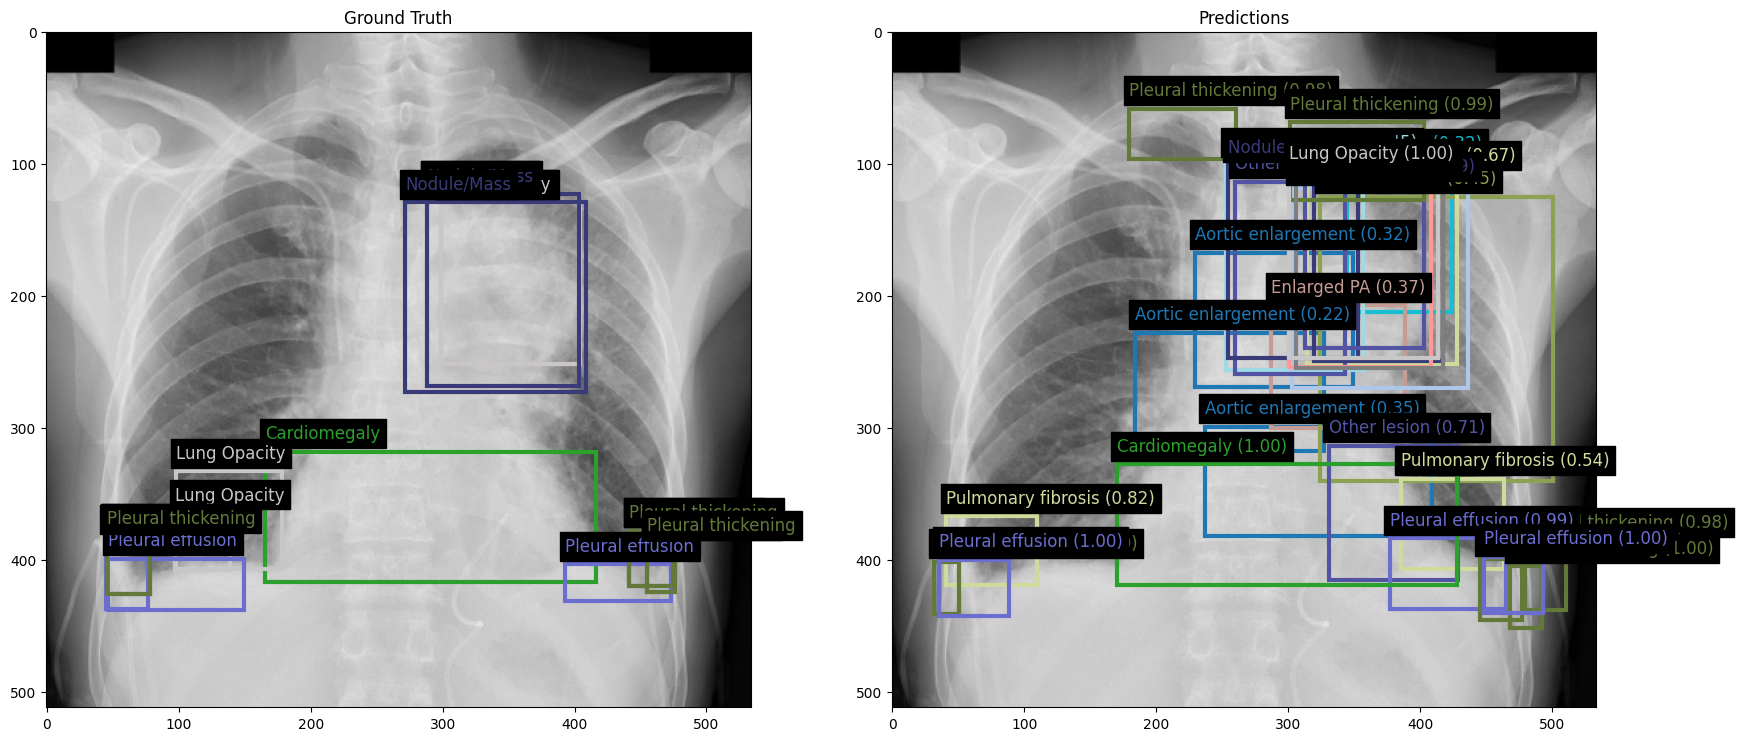

In [41]:
i = 625
i = idxs[i]
print(tmp['sample_ious'][i])
visualize_predicted_bounding_boxes__yolo(
    image_path=tmp['image_paths'][i],
    pred_coords=tmp['pred_boxes_list'][i],
    pred_classes=tmp['pred_classes_list'][i],
    pred_confs=tmp['pred_confs_list'][i],
    gt_bbox_coords=tmp['gt_bboxes'][i],
    class_names=VINBIG_BBOX_NAMES,
    figsize=(20, 10),
    format='xyxy',
)

In [237]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.05 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,Adaptive

iou_th=0.1, conf_th=0.3, mAP=0.21285335768481578 (time_input_processing=1.4212632179260254, time_map=1.5613293647766113)
iou_th=0.2, conf_th=0.3, mAP=0.21481562156494832 (time_input_processing=1.4012439250946045, time_map=1.7112152576446533)
iou_th=0.3, conf_th=0.3, mAP=0.2123034239882527 (time_input_processing=1.6750328540802002, time_map=1.8930144309997559)
iou_th=0.4, conf_th=0.3, mAP=0.2114619054365659 (time_input_processing=1.41766357421875, time_map=2.122950315475464)
iou_th=0.5, conf_th=0.3, mAP=0.2059878034520273 (time_input_processing=1.4228854179382324, time_map=2.4600119590759277)
iou_th=0.1, conf_th=0.4, mAP=0.2128858288036254 (time_input_processing=1.3853273391723633, time_map=1.4894113540649414)
iou_th=0.2, conf_th=0.4, mAP=0.21497524083527503 (time_input_processing=1.3860771656036377, time_map=1.6168768405914307)
iou_th=0.3, conf_th=0.4, mAP=0.2126868386322812 (time_input_processing=1.3713436126708984, time_map=1.7768633365631104)
iou_th=0.4, conf_th=0.4, mAP=0.211876901

In [275]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbi

iou_th=0.5, conf_th=0.2, mAP=0.22681358303640178 (time_input_processing=1.4704170227050781, time_map=2.8502895832061768)
iou_th=0.02, conf_th=0.3, mAP=0.22987994495274303 (time_input_processing=1.41888427734375, time_map=1.5441787242889404)
iou_th=0.05, conf_th=0.3, mAP=0.2289466736859538 (time_input_processing=1.419753074645996, time_map=1.5800085067749023)
iou_th=0.1, conf_th=0.3, mAP=0.229847932065386 (time_input_processing=1.4125938415527344, time_map=1.6474854946136475)
iou_th=0.2, conf_th=0.3, mAP=0.2316389208691976 (time_input_processing=1.4143052101135254, time_map=1.8003439903259277)
iou_th=0.3, conf_th=0.3, mAP=0.227953278183278 (time_input_processing=1.4149465560913086, time_map=2.2675180435180664)
iou_th=0.4, conf_th=0.3, mAP=0.2292200226595453 (time_input_processing=1.4164955615997314, time_map=2.2465481758117676)
iou_th=0.5, conf_th=0.3, mAP=0.2257527318926732 (time_input_processing=1.416682243347168, time_map=2.573362350463867)
iou_th=0.02, conf_th=0.4, mAP=0.22863603813

In [30]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.20,0.20,50),use_classifier_confs).pkl')

mAP@0.0: 0.3796449402749928
mAP@0.02: 0.35388021696659
mAP@0.05: 0.32853463251658116
mAP@0.1: 0.2909711788539044
mAP@0.2: 0.22419969053748165
mAP@0.3: 0.17552839432093365
mAP@0.4: 0.13672884926647164
mAP@0.5: 0.11061779676692725
mAP@0.6: 0.0832069950108797
mAP@0.7: 0.05918209196581829
micro_AP@0.0: 0.4658610496663999
micro_AP@0.02: 0.43306810654885014
micro_AP@0.05: 0.4022612567896444
micro_AP@0.1: 0.35784418601656115
micro_AP@0.2: 0.28316874098771183
micro_AP@0.3: 0.23384504884116025
micro_AP@0.4: 0.18819215278184112
micro_AP@0.5: 0.15329907844198015
micro_AP@0.6: 0.10224245634199547
micro_AP@0.7: 0.05684598243951805
vinbigdata mAP@0.4: 0.16664905665460608
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.19484297075339427


In [7]:
tmp = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.20,0.20,50),use_classifier_confs).pkl')

In [8]:
tmp.keys()

dict_keys(['image_paths', 'pred_boxes_list', 'pred_classes_list', 'pred_confs_list', 'classifier_confs', 'gt_bboxes', 'class_ious', 'sample_ious', 'micro_iou', 'macro_iou', 'map_iou_thresholds', 'map_per_class', 'prc_auc', 'best_iou_threshold', 'best_conf_threshold', 'max_det'])

In [9]:
idxs = np.argsort(tmp['sample_ious'])[::-1]

In [56]:
class_idx = VINBIG_BBOX_NAMES.index('Clavicle fracture')

In [57]:
filtered_idxs = [idx for idx in idxs if len(tmp['gt_bboxes'][idx][class_idx]) > 0]

In [58]:
len(filtered_idxs)

2

0.12786645
image_path=/mnt/workspace/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/0799063103aea263344a77adbde5b7ca.jpg


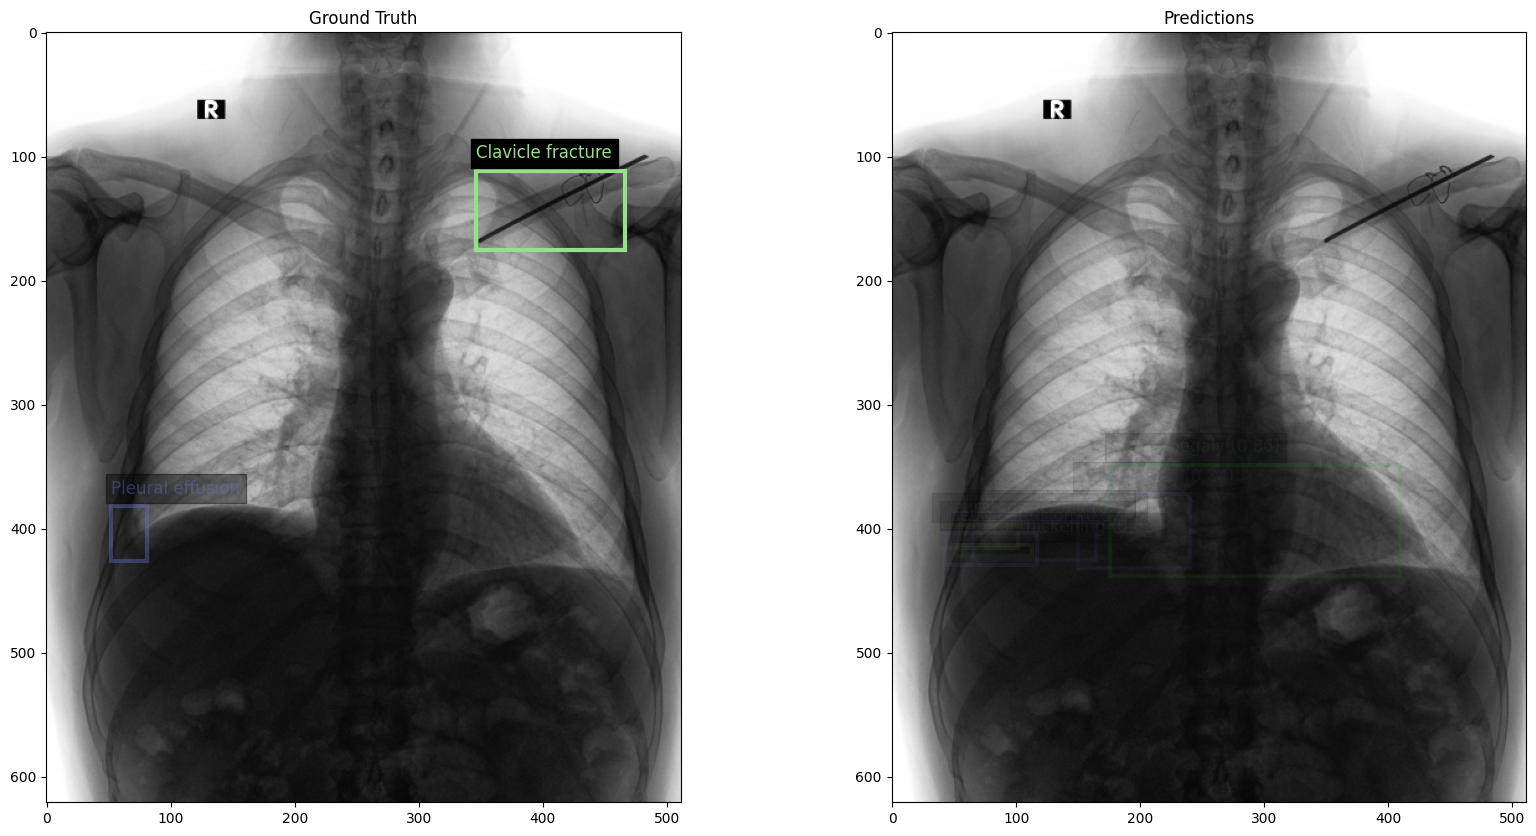

In [61]:
i = 1
i = filtered_idxs[i]
print(tmp['sample_ious'][i])
visualize_predicted_bounding_boxes__yolo(
    image_path=tmp['image_paths'][i],
    pred_coords=tmp['pred_boxes_list'][i],
    pred_classes=tmp['pred_classes_list'][i],
    pred_confs=tmp['pred_confs_list'][i],
    gt_bbox_coords=tmp['gt_bboxes'][i],
    class_names=VINBIG_BBOX_NAMES,
    figsize=(20, 10),
    format='xyxy',
    classes_to_highlight=['Clavicle fracture']
)

In [17]:
from medvqa.datasets.vinbig import compute_label_frequencies

In [18]:
label_frequencies = compute_label_frequencies()

In [25]:
vals = tmp['prc_auc']['per_class'][:]
vals[tmp['prc_auc']['per_class'].index(0.5)] = 0

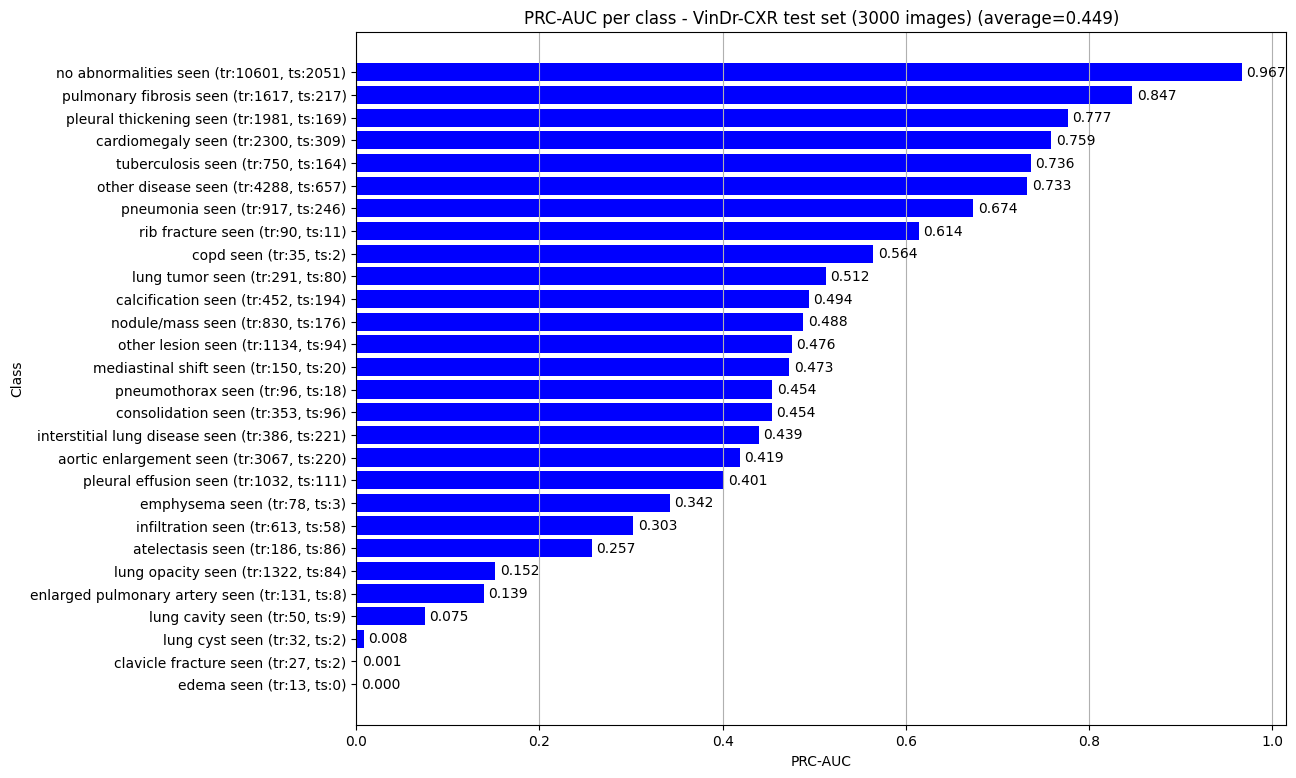

In [26]:
from medvqa.utils.constants import VINBIG_LABELS, VINBIG_LABEL2PHRASE

plot_metrics(
    metric_names=[f'{VINBIG_LABEL2PHRASE[x]} (tr:{label_frequencies["train"][x]}, ts:{label_frequencies["test"][x]})' for x in VINBIG_LABELS],
    metric_values=vals,
    title='PRC-AUC per class - VinDr-CXR test set (3000 images)',
    ylabel='Class',
    xlabel='PRC-AUC',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 9),
    append_average_to_title=True,
)

In [28]:
tmp['class_ious'].shape

(22,)

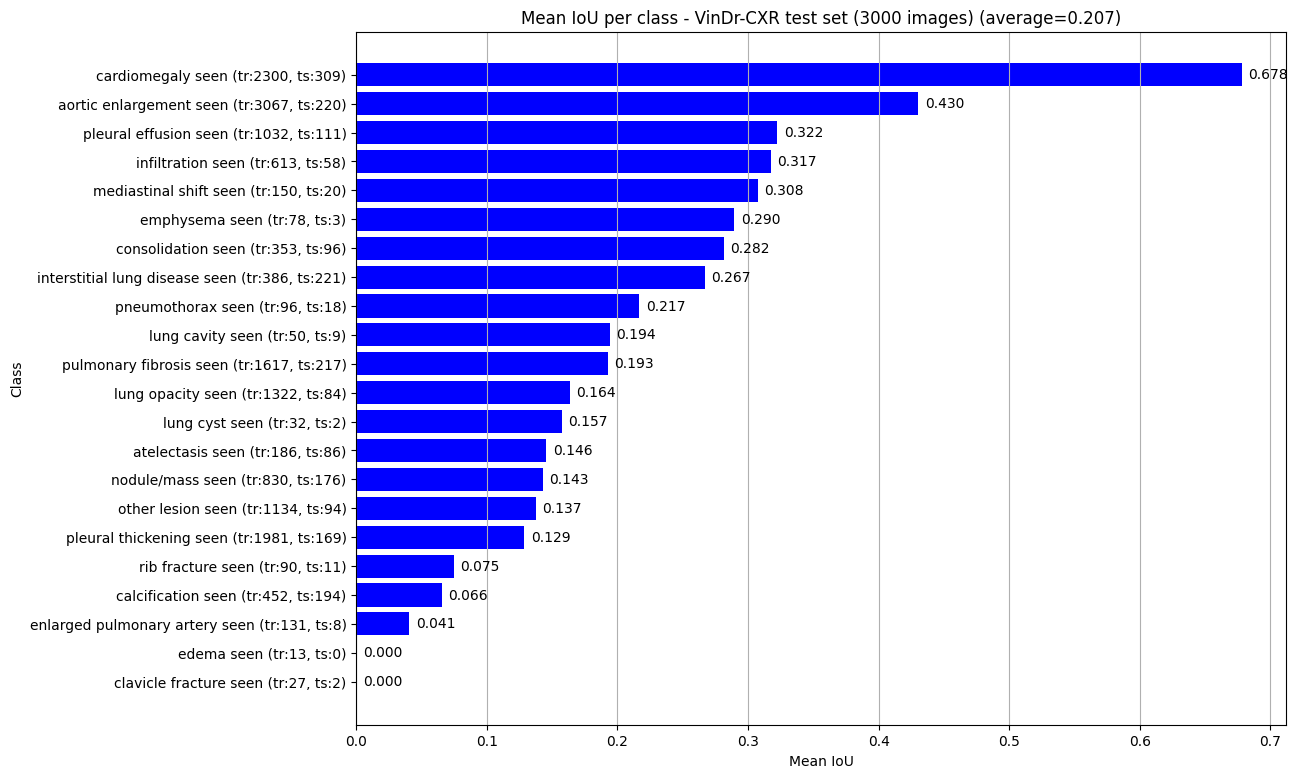

In [29]:
from medvqa.utils.constants import VINBIG_BBOX_NAMES, VINBIG_LABEL2PHRASE

plot_metrics(
    metric_names=[f'{VINBIG_LABEL2PHRASE[x]} (tr:{label_frequencies["train"][x]}, ts:{label_frequencies["test"][x]})' for x in VINBIG_BBOX_NAMES],
    metric_values=tmp['class_ious'],
    title='Mean IoU per class - VinDr-CXR test set (3000 images)',
    ylabel='Class',
    xlabel='Mean IoU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 9),
    append_average_to_title=True,
)

In [32]:
tmp['map_iou_thresholds'],

[0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

In [31]:
tmp['map_per_class'].shape

(8, 22)

In [33]:
import pandas as pd
metric_names = [f'{VINBIG_LABEL2PHRASE[x]} (tr:{label_frequencies["train"][x]}, ts:{label_frequencies["test"][x]})' for x in VINBIG_BBOX_NAMES]
df = pd.DataFrame(data=tmp['map_per_class'], columns=metric_names)
df

aortic enlargement seen (tr:3067, ts:220)  \
0                                   0.426708   
1                                   0.426708   
2                                   0.420385   
3                                   0.412199   
4                                   0.369258   
5                                   0.308731   
6                                   0.243277   
7                                   0.151277   

   atelectasis seen (tr:186, ts:86)  calcification seen (tr:452, ts:194)  \
0                          0.253015                             0.432987   
1                          0.220471                             0.299126   
2                          0.173476                             0.209879   
3                          0.136276                             0.138592   
4                          0.076906                             0.079588   
5                          0.051169                             0.068057   
6                          0.046766                             0.065082   
7                          0.032809                             0.064074   

   cardiomegaly seen (tr:2300, ts:309)  clavicle fracture seen (tr:27, ts:2)  \
0                             0.761459                              0.000667   
1                             0.761459                              0.000667   
2                             0.761459                              0.000667   
3                             0.761459                              0.000667   
4                             0.761459                              0.000667   
5                             0.761459                              0.000667   
6                             0.750713                              0.000667   
7                             0.704248                              0.000667   

   consolidation seen (tr:353, ts:96)  edema seen (tr:13, ts:0)  \
0                            0.449632                      -0.0   
1                            0.434620                      -0.0   
2                            0.431373                      -0.0   
3                            0.400587                      -0.0   
4                            0.332192                      -0.0   
5                            0.234230                      -0.0   
6                            0.125036                      -0.0   
7                            0.110203                      -0.0   

   emphysema seen (tr:78, ts:3)  \
0                      0.348677   
1                      0.343329   
2                      0.343329   
3                      0.334000   
4                      0.334000   
5                      0.334000   
6                      0.334000   
7                      0.334000   

   enlarged pulmonary artery seen (tr:131, ts:8)  \
0                                       0.135589   
1                                       0.135589   
2                                       0.135589   
3                                       0.127333   
4                                       0.002667   
5                                       0.002667   
6                                       0.002667   
7                                       0.002667   

   interstitial lung disease seen (tr:386, ts:221)  ...  \
0                                         0.424987  ...   
1                                         0.396750  ...   
2                                         0.365699  ...   
3                                         0.340097  ...   
4                                         0.263013  ...   
5                                         0.224609  ...   
6                                         0.175278  ...   
7                                         0.151454  ...   

   lung cavity seen (tr:50, ts:9)  lung cyst seen (tr:32, ts:2)  \
0                        0.090091                      0.018829   
1                        0.090091                      0.006662   
2                        0.090091         

In [47]:
reload(medvqa.evaluation.plots)

<module 'medvqa.evaluation.plots' from '/home/pamessina/medvqa/medvqa/evaluation/plots.py'>

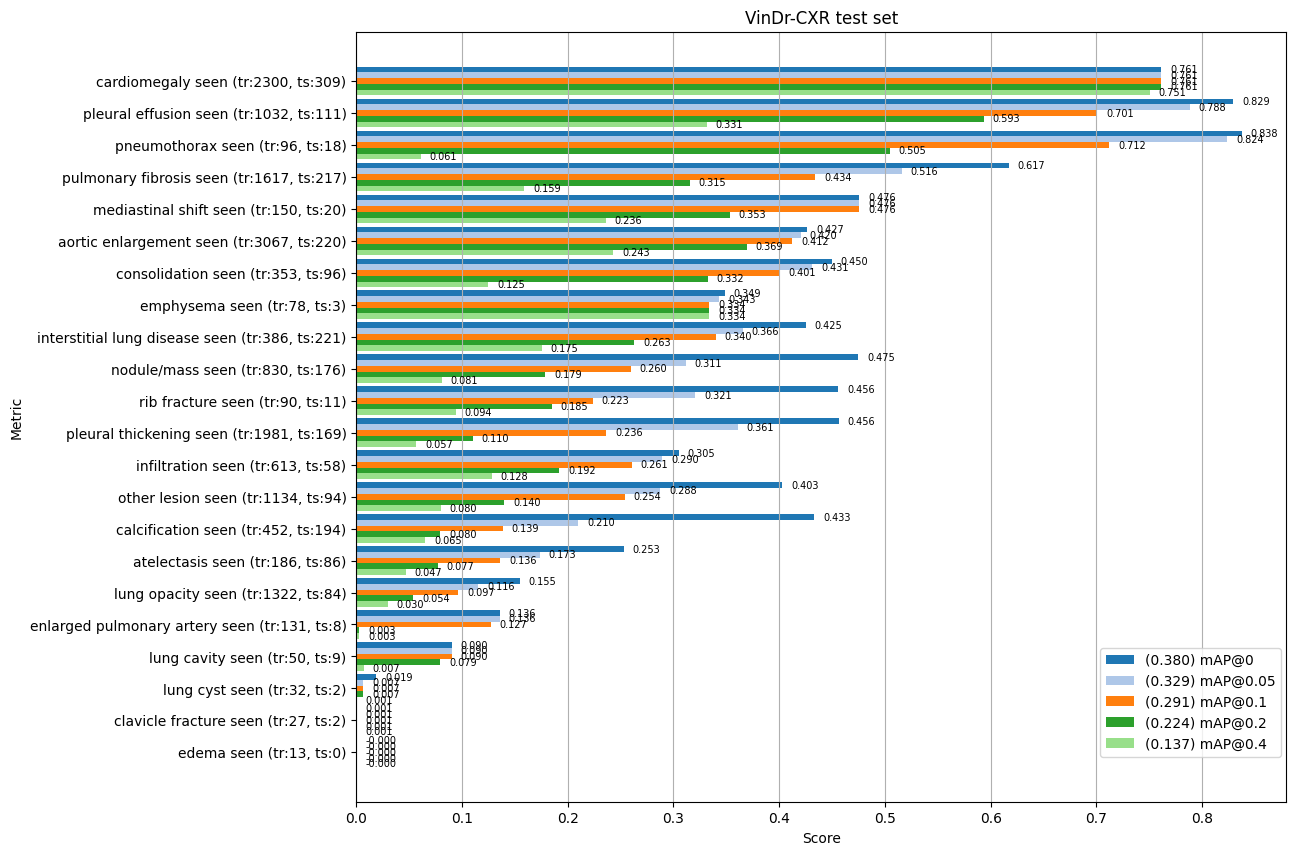

In [57]:
from medvqa.evaluation.plots import plot_metric_bars_per_method

metric_names = [f'{VINBIG_LABEL2PHRASE[x]} (tr:{label_frequencies["train"][x]}, ts:{label_frequencies["test"][x]})' for x in VINBIG_BBOX_NAMES]
dataframe_rows = [df.iloc[0], df.iloc[2], df.iloc[3], df.iloc[4], df.iloc[6]]
method_aliases = ['mAP@0', 'mAP@0.05', 'mAP@0.1', 'mAP@0.2', 'mAP@0.4']
plot_metric_bars_per_method(
    dataframe_rows=dataframe_rows,
    method_aliases=method_aliases,
    metric_names=metric_names,
    metric_aliases=metric_names,
    title='VinDr-CXR test set',
    figsize=(12, 10),
    bbox_to_anchor=(0.8, 0.2)
#     figsize=(8, 15),
#     sort_metrics=True,
#     vertical=True,
)

# 15) microsoft-rad-dino-maira-2+CXRFE+FiLM Attention Pooling+BBox+Classif; VinDR-CXR

In [163]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
do_visual_grounding_with_segmentation = False
--------------------------------------------------
1) device = cuda
----------------------------------

In [164]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.17359745572300675

In [296]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_133017_vinbig_Ph

conf_th=0.2, iou_th=0.5, mAP=0.20444610360527998 (time_input_processing=1.527787208557129, time_map=2.295682191848755)
conf_th=0.3, iou_th=0.02, mAP=0.19873570622881653 (time_input_processing=1.482710361480713, time_map=1.3770794868469238)
conf_th=0.3, iou_th=0.05, mAP=0.19874612833324468 (time_input_processing=1.4863665103912354, time_map=1.3912415504455566)
conf_th=0.3, iou_th=0.1, mAP=0.2028823144435261 (time_input_processing=1.4848690032958984, time_map=1.4295685291290283)
conf_th=0.3, iou_th=0.2, mAP=0.2032090049911381 (time_input_processing=1.4875423908233643, time_map=1.5040011405944824)
conf_th=0.3, iou_th=0.3, mAP=0.20368797459195306 (time_input_processing=1.4845149517059326, time_map=1.6272733211517334)
conf_th=0.3, iou_th=0.4, mAP=0.2040680819068552 (time_input_processing=1.4913763999938965, time_map=1.70383620262146)
conf_th=0.3, iou_th=0.5, mAP=0.20344683201734848 (time_input_processing=1.4871220588684082, time_map=1.901602029800415)
conf_th=0.4, iou_th=0.02, mAP=0.1978929

In [34]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.40,0.10,50),use_classifier_confs).pkl')

mAP@0.0: 0.329055921063104
mAP@0.02: 0.2934680900262279
mAP@0.05: 0.27983648576350945
mAP@0.1: 0.26206192546028023
mAP@0.2: 0.21297026070639574
mAP@0.3: 0.17139668053902765
mAP@0.4: 0.13133398093076767
mAP@0.5: 0.10204611726395342
mAP@0.6: 0.07559014987366407
mAP@0.7: 0.05372481732860313
micro_AP@0.0: 0.4176985789680404
micro_AP@0.02: 0.37333281470223856
micro_AP@0.05: 0.3554222370680171
micro_AP@0.1: 0.3286661771894111
micro_AP@0.2: 0.2765185349056811
micro_AP@0.3: 0.22828125420433676
micro_AP@0.4: 0.18294809926074998
micro_AP@0.5: 0.13908558776944763
micro_AP@0.6: 0.09515053876784944
micro_AP@0.7: 0.05546066424957348
vinbigdata mAP@0.4: 0.18209089602870376
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.1927878684530909


# 16) Phrase Grounding: DN121+CXRFE+FiLM-attention+bbox;VinDR-CXR (average of 10 facts from MIMIC-CXR)

In [13]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241204_083305_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241204_083305_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241204_083305_vinbig_PhraseGrounder(dn121,FiLM_Si

conf_th=0.2, iou_th=0.5, mAP=0.17144770945911333 (time_input_processing=1.8631768226623535, time_map=3.611206293106079)
conf_th=0.3, iou_th=0.02, mAP=0.17881834110194442 (time_input_processing=1.768132209777832, time_map=1.8202636241912842)
conf_th=0.3, iou_th=0.05, mAP=0.1787797967531929 (time_input_processing=1.7714917659759521, time_map=1.8543267250061035)
conf_th=0.3, iou_th=0.1, mAP=0.17905681883995664 (time_input_processing=1.7788341045379639, time_map=1.9646937847137451)
conf_th=0.3, iou_th=0.2, mAP=0.1797091988748127 (time_input_processing=1.7813489437103271, time_map=2.1680331230163574)
conf_th=0.3, iou_th=0.3, mAP=0.178096617327841 (time_input_processing=2.0446574687957764, time_map=2.4624929428100586)
conf_th=0.3, iou_th=0.4, mAP=0.17564473810743952 (time_input_processing=1.7677116394042969, time_map=2.7894840240478516)
conf_th=0.3, iou_th=0.5, mAP=0.1714208377896217 (time_input_processing=1.7791836261749268, time_map=3.3226068019866943)
conf_th=0.4, iou_th=0.02, mAP=0.17855

In [40]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241204_083305_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.20,0.20),use_classifier_confs).pkl')

mAP@0.0: 0.30184919893961
mAP@0.02: 0.27029352242648885
mAP@0.05: 0.25174131988666626
mAP@0.1: 0.21816650980517086
mAP@0.2: 0.16790555951274694
mAP@0.3: 0.13132314759623126
mAP@0.4: 0.10998802851071106
mAP@0.5: 0.08682491276633163
mAP@0.6: 0.0669134873568472
mAP@0.7: 0.04640124505457976
micro_AP@0.0: 0.42758379368860105
micro_AP@0.02: 0.390071338468723
micro_AP@0.05: 0.3628406287940753
micro_AP@0.1: 0.3211114745358288
micro_AP@0.2: 0.2553909038106014
micro_AP@0.3: 0.20778012382753167
micro_AP@0.4: 0.17340431331077916
micro_AP@0.5: 0.13599603553698095
micro_AP@0.6: 0.10330515926741861
micro_AP@0.7: 0.05981498426689351
vinbigdata mAP@0.4: 0.1577354890536876
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.16746040240592025


# 17) Uniformer (no medical pretraining)+CXRFE+FiLM Attention Pooling+BBox+Classif; VinDR-CXR

In [15]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241203_181237_vinbig_PhraseGrounder(aehrc-uniformer-base-tl-384,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241203_181237_vinbig_PhraseGrounder(aehrc-uniformer-base-tl-384,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241203_181237_vinbig_PhraseGrounder(a

conf_th=0.2, iou_th=0.5, mAP=0.1995700780322795 (time_input_processing=1.5490052700042725, time_map=3.235145330429077)
conf_th=0.3, iou_th=0.02, mAP=0.2009741567077053 (time_input_processing=1.4878277778625488, time_map=1.7991342544555664)
conf_th=0.3, iou_th=0.05, mAP=0.20239593744929377 (time_input_processing=1.4999382495880127, time_map=2.149451971054077)
conf_th=0.3, iou_th=0.1, mAP=0.20264697148247085 (time_input_processing=1.4961998462677002, time_map=1.9307265281677246)
conf_th=0.3, iou_th=0.2, mAP=0.20496418730204066 (time_input_processing=1.500481128692627, time_map=2.120265483856201)
conf_th=0.3, iou_th=0.3, mAP=0.2037158090295172 (time_input_processing=1.4914684295654297, time_map=2.3387022018432617)
conf_th=0.3, iou_th=0.4, mAP=0.2019278580189937 (time_input_processing=1.498408555984497, time_map=2.635566234588623)
conf_th=0.3, iou_th=0.5, mAP=0.1992184203706774 (time_input_processing=1.500654697418213, time_map=2.9801690578460693)
conf_th=0.4, iou_th=0.02, mAP=0.1998116083

In [33]:
compute_map_metrics_from_results(results_path='/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241203_181237_vinbig_PhraseGrounder(aehrc-uniformer-base-tl-384,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.20,0.20),use_classifier_confs).pkl')

mAP@0.0: 0.33427463858289275
mAP@0.02: 0.30748262914487695
mAP@0.05: 0.2846896430410389
mAP@0.1: 0.25256971865050765
mAP@0.2: 0.19504484754717238
mAP@0.3: 0.15807562371908548
mAP@0.4: 0.12905255925339046
mAP@0.5: 0.08628566442380507
mAP@0.6: 0.06468959249159088
mAP@0.7: 0.045244907059133505
micro_AP@0.0: 0.4467809216759334
micro_AP@0.02: 0.40873508337299536
micro_AP@0.05: 0.38307984068226614
micro_AP@0.1: 0.34326494238995964
micro_AP@0.2: 0.27872307435358434
micro_AP@0.3: 0.22540698515748997
micro_AP@0.4: 0.1866718645354045
micro_AP@0.5: 0.14392480981680023
micro_AP@0.6: 0.10172437145400513
micro_AP@0.7: 0.05791511669221186
vinbigdata mAP@0.4: 0.16535190998329136
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.17759012076321024


# 18) YOLOv11 (fact-conditioned)+CXRFE; VinDR-CXR

In [8]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241208_172651_vinbig_PhraseGrounder(yolo11l(fact_cond,cls,det,128,[256,128],256),AdaptiveFiLM_MLP_YOLOv11)" \
--num_workers 3 \
--max_images_per_batch 30 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--use_classifier_confs_for_map \
--use_amp \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241208_172651_vinbig_PhraseGrounder(yolo11l(fact_cond,cls,det,128,[256,128],256),AdaptiveFiLM_MLP_YOLOv11)
   max_images_per_batch: 30
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   use_amp: True
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241208_172651_vinbig_PhraseGrounder(yolo11l(fact_cond,cls,det,128,[256,128],256),AdaptiveFiLM_MLP_YOLOv11)/

PRC-AUC(aortic enlargement seen): 0.3306503772491289
PRC-AUC(atelectasis seen): 0.2123225470725567
PRC-AUC(calcification seen): 0.21966594357670477
PRC-AUC(cardiomegaly seen): 0.5659581284538102
PRC-AUC(clavicle fracture seen): 0.0018250865485576206
PRC-AUC(consolidation seen): 0.12608519486716996
PRC-AUC(edema seen): 0.5
PRC-AUC(emphysema seen): 0.08579155891886904
PRC-AUC(enlarged pulmonary artery seen): 0.009573641107687166
PRC-AUC(interstitial lung disease seen): 0.17090381103593336
PRC-AUC(infiltration seen): 0.08575381399741286
PRC-AUC(lung opacity seen): 0.09436710117732887
PRC-AUC(lung cavity seen): 0.018521779451116577
PRC-AUC(lung cyst seen): 0.0028162404856420836
PRC-AUC(mediastinal shift seen): 0.08692890147538868
PRC-AUC(nodule/mass seen): 0.12012928115984778
PRC-AUC(other lesion seen): 0.12369321531487544
PRC-AUC(pleural effusion seen): 0.3339684485695988
PRC-AUC(pleural thickening seen): 0.18971820538345827
PRC-AUC(pneumothorax seen): 0.058319640455246465
PRC-AUC(pulmona

In [13]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241208_172651_vinbig_PhraseGrounder(yolo11l(fact_cond,cls,det,128,[256,128],256),AdaptiveFiLM_MLP_YOLOv11)" \
--num_workers 3 \
--max_images_per_batch 30 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--use_amp \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241208_172651_vinbig_PhraseGrounder(yolo11l(fact_cond,cls,det,128,[256,128],256),AdaptiveFiLM_MLP_YOLOv11)
   max_images_per_batch: 30
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   use_amp: True
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241208_172651_vinbig_PhraseGrounder(yolo11l(

mAP@0.0: 0.13795253049789685
mAP@0.02: 0.1273266703309421
mAP@0.05: 0.1252449708734816
mAP@0.1: 0.12245144999769376
mAP@0.2: 0.1119747085999188
mAP@0.3: 0.09671627237459252
mAP@0.4: 0.08588667705891273
mAP@0.5: 0.07200292600245647
micro_AP@0.0: 0.19630794015336836
micro_AP@0.02: 0.1840329210964883
micro_AP@0.05: 0.18062603335851968
micro_AP@0.1: 0.1769527213818029
micro_AP@0.2: 0.16430368038760657
micro_AP@0.3: 0.14810825952394546
micro_AP@0.4: 0.1343172005939315
micro_AP@0.5: 0.11775813104116722
Saving metrics to file ...
Saved metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241208_172651_vinbig_PhraseGrounder(yolo11l(fact_cond,cls,det,128,[256,128],256),AdaptiveFiLM_MLP_YOLOv11)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.02,0.10),use_classifier_confs).pkl


In [28]:
compute_map_metrics_from_results(results_path='/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241208_172651_vinbig_PhraseGrounder(yolo11l(fact_cond,cls,det,128,[256,128],256),AdaptiveFiLM_MLP_YOLOv11)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.02,0.10),use_classifier_confs).pkl')

mAP@0.0: 0.13795253049789685
mAP@0.02: 0.1273266703309421
mAP@0.05: 0.1252449708734816
mAP@0.1: 0.12245144999769376
mAP@0.2: 0.1119747085999188
mAP@0.3: 0.09671627237459252
mAP@0.4: 0.08588667705891273
mAP@0.5: 0.07200292600245647
mAP@0.6: 0.05976586912561606
mAP@0.7: 0.047417183326962584
micro_AP@0.0: 0.19630794015336836
micro_AP@0.02: 0.1840329210964883
micro_AP@0.05: 0.18062603335851968
micro_AP@0.1: 0.1769527213818029
micro_AP@0.2: 0.16430368038760657
micro_AP@0.3: 0.14810825952394546
micro_AP@0.4: 0.1343172005939315
micro_AP@0.5: 0.11775813104116722
micro_AP@0.6: 0.09425190401025997
micro_AP@0.7: 0.062034279151396914
vinbigdata mAP@0.4: 0.11715426236241842
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.11835277549052277


# 19) YOLOv11 (feature extraction)+CXRFE+FiLM Attention Pooling+BBox+Classif; VinDR-CXR

In [3]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241211_162359_vinbig_PhraseGrounder(YOLOv11FeatureExtractor(yolo11l),AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 30 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--use_amp \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241211_162359_vinbig_PhraseGrounder(YOLOv11FeatureExtractor(yolo11l),AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 30
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: True
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241211_162359_vinbig_Ph

mAP(micro_avg): 0.3592350824790221
mAP(macro_avg): 0.17552832116446698
Using classifier confidences for mAP computation
classifier_confs.shape = (3000, 22)
Finding optimal conf and iou thresholds
conf_th=0.1, iou_th=0.02, mAP=0.06258767388218306 (time_input_processing=2.132866859436035, time_map=3.40722393989563)
conf_th=0.1, iou_th=0.05, mAP=0.06365540950375281 (time_input_processing=2.057518243789673, time_map=3.9529876708984375)
conf_th=0.1, iou_th=0.1, mAP=0.0635851054262785 (time_input_processing=2.041339159011841, time_map=4.066857814788818)
conf_th=0.1, iou_th=0.2, mAP=0.0639227257296837 (time_input_processing=2.0817272663116455, time_map=4.986088752746582)
conf_th=0.1, iou_th=0.3, mAP=0.06338010721364747 (time_input_processing=2.3511478900909424, time_map=6.0928614139556885)
conf_th=0.1, iou_th=0.4, mAP=0.06454312611000236 (time_input_processing=2.1027402877807617, time_map=7.385729551315308)
conf_th=0.1, iou_th=0.5, mAP=0.06530488457463096 (time_input_processing=2.389275074005

Saved metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241211_162359_vinbig_PhraseGrounder(YOLOv11FeatureExtractor(yolo11l),AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.50,0.20),use_classifier_confs).pkl


In [27]:
compute_map_metrics_from_results(results_path='/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241211_162359_vinbig_PhraseGrounder(YOLOv11FeatureExtractor(yolo11l),AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.50,0.20),use_classifier_confs).pkl')

mAP@0.0: 0.12337821683332754
mAP@0.02: 0.10006981981471785
mAP@0.05: 0.08568271932957994
mAP@0.1: 0.06991384243844072
mAP@0.2: 0.0590510343969602
mAP@0.3: 0.052725088210361176
mAP@0.4: 0.04551320934215677
mAP@0.5: 0.039934356407050696
mAP@0.6: 0.03750126392431316
mAP@0.7: 0.03599196511152424
micro_AP@0.0: 0.1662926658216978
micro_AP@0.02: 0.14206788702464102
micro_AP@0.05: 0.12612695872032537
micro_AP@0.1: 0.11217428781593679
micro_AP@0.2: 0.09421166669278588
micro_AP@0.3: 0.07520013300625437
micro_AP@0.4: 0.05511854051463802
micro_AP@0.5: 0.040305584800760144
micro_AP@0.6: 0.034360438015917864
micro_AP@0.7: 0.03224903261544243
vinbigdata mAP@0.4: 0.06429631417671279
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.06484858280689702


# 20) MedSAM(feature extraction)+CXRFE+FiLM Attention Pooling+BBox+Classif; VinDR-CXR

In [5]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241220_102157_vinbig_PhraseGrounder(wanglab-medsam-vit-base,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 8 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--use_amp \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241220_102157_vinbig_PhraseGrounder(wanglab-medsam-vit-base,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 8
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: True
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241220_102157_vinbig_PhraseGround

conf_th=0.2, iou_th=0.2, mAP=0.11955899603118803 (time_input_processing=2.045609474182129, time_map=2.132370948791504)
conf_th=0.2, iou_th=0.3, mAP=0.11888254218971386 (time_input_processing=2.0453741550445557, time_map=2.2363204956054688)
conf_th=0.2, iou_th=0.4, mAP=0.11951237420832696 (time_input_processing=2.0491809844970703, time_map=2.6562306880950928)
conf_th=0.2, iou_th=0.5, mAP=0.1200319371786199 (time_input_processing=2.049748659133911, time_map=2.592710256576538)
conf_th=0.3, iou_th=0.02, mAP=0.11849187623154167 (time_input_processing=2.039421319961548, time_map=1.9146349430084229)
conf_th=0.3, iou_th=0.05, mAP=0.11863842071496725 (time_input_processing=2.0351855754852295, time_map=1.9187970161437988)
conf_th=0.3, iou_th=0.1, mAP=0.11898237948599893 (time_input_processing=2.0268421173095703, time_map=2.2440407276153564)
conf_th=0.3, iou_th=0.2, mAP=0.11946465720342844 (time_input_processing=2.0552594661712646, time_map=2.0216071605682373)
conf_th=0.3, iou_th=0.3, mAP=0.11878

In [6]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241220_102157_vinbig_PhraseGrounder(wanglab-medsam-vit-base,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.50,0.10),use_classifier_confs).pkl')

mAP@0.0: 0.2166070889551959
mAP@0.02: 0.17046794972278495
mAP@0.05: 0.16184255334787984
mAP@0.1: 0.14554746976523408
mAP@0.2: 0.11876149532600139
mAP@0.3: 0.10017434551677783
mAP@0.4: 0.07830575695497505
mAP@0.5: 0.06197295046478762
mAP@0.6: 0.04850085057227124
mAP@0.7: 0.03861596036291327
micro_AP@0.0: 0.30958405826354296
micro_AP@0.02: 0.24311746926118402
micro_AP@0.05: 0.2326086289626001
micro_AP@0.1: 0.21016492207833012
micro_AP@0.2: 0.17962781385751186
micro_AP@0.3: 0.1529026789651921
micro_AP@0.4: 0.12576187595902552
micro_AP@0.5: 0.09704604786016166
micro_AP@0.6: 0.06558063254660985
micro_AP@0.7: 0.04084089601372439
vinbigdata mAP@0.4: 0.11985332015807848
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.12200688460906517
